# Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

<br>

1. Выгрузить и изучить данные. 
2. Предобратока данных: подготовить данные, изменить типы данных; определить и использовать общие номера партий по всем таблицам.
3. Добавить новые признаки и составить единую таблицу со всеми необходимыммии данными. 
4. Подобрать модель которая  предскажет те мпеарутуру стали с необходимой точностью. 
5. СОставить выводы. 

# Изучение данных

Импорт необходимых библиотек

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

import matplotlib.pyplot as plt

from IPython.display import Image

import numpy as np
import copy

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn import linear_model

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

RANDOM_STATE = 80822

**Выгрузка имеющихся данных**

## data_arc.csv — данные об электродах;

Выгрузка и изучение данных об электродах.

In [4]:
try:  
    data_arc = pd.read_csv('C:/projects/final/data_arc.csv')
except OSError as e:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(data_arc.head())
display(data_arc.info())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

`Начало нагрева дугой` - дата начала нагрева электродами;

`Конец нагрева дугой` - дата окончания нагрева электродами;

`Активная мощность` - среднее значение мгновенной мощности за период;

`Реактивная мощность` - величина, характеризующая нагрузки, создаваемые в электротехнических устройствах колебаниями энергии электромагнитного поля в цепи синусоидального переменного тока.

In [5]:
display(data_arc.describe())

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Столбец `Реактивная мощность` имеет отрицательное значение -715.504924 - это выброс. График будем строить не учитывая данное значение.

Посмотрим на уникальные значения столбца `key`

In [6]:
data_arc['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

Построение гистограмм

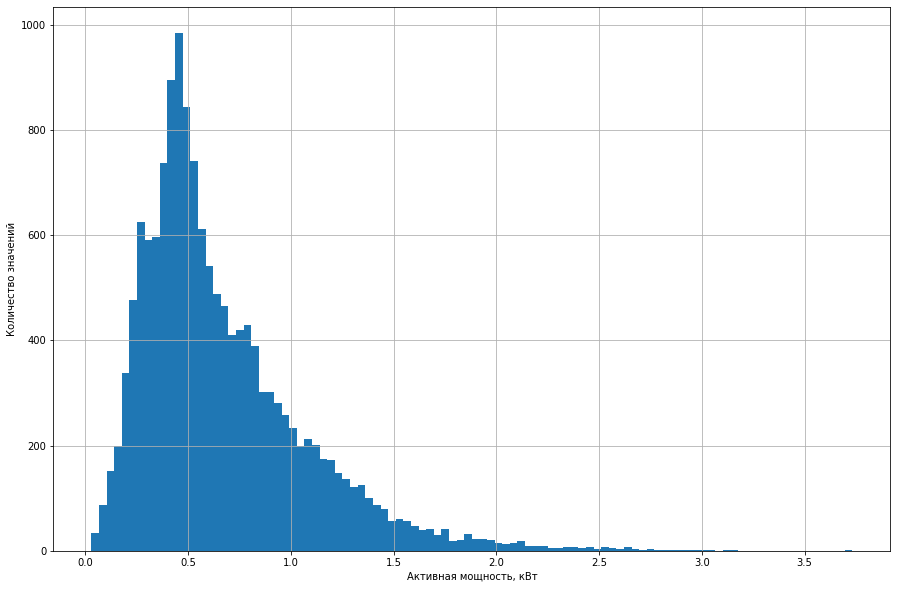

In [7]:
data_arc['Активная мощность'].hist(bins=100, figsize=(15,10))
plt.xlabel("Активная мощность, кВт");
plt.ylabel("Количество значений");

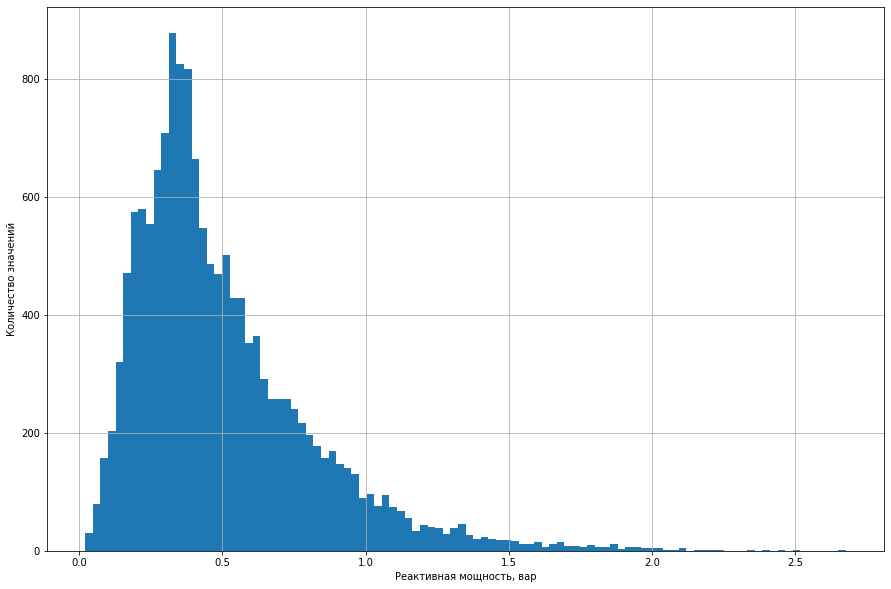

In [8]:
data_arc[data_arc['Реактивная мощность'] > 0]['Реактивная мощность'].hist(bins=100, figsize=(15,10))
plt.xlabel("Реактивная мощность, вар");
plt.ylabel("Количество значений");

**Вывод**

- Значения столбца `активная мощность` не имюет выбросов в то время как столбец `реактивная мощность` имеет одно отриц . значение которое подлежит удалению в предобработке данных.
- На этапе предобратки данных добавить новые признаки. Также найти среднюю мощность и просуммирвать время нагрева для того, чтобы скомпановать данные для каждого ключа по дной строке.

<AxesSubplot:>

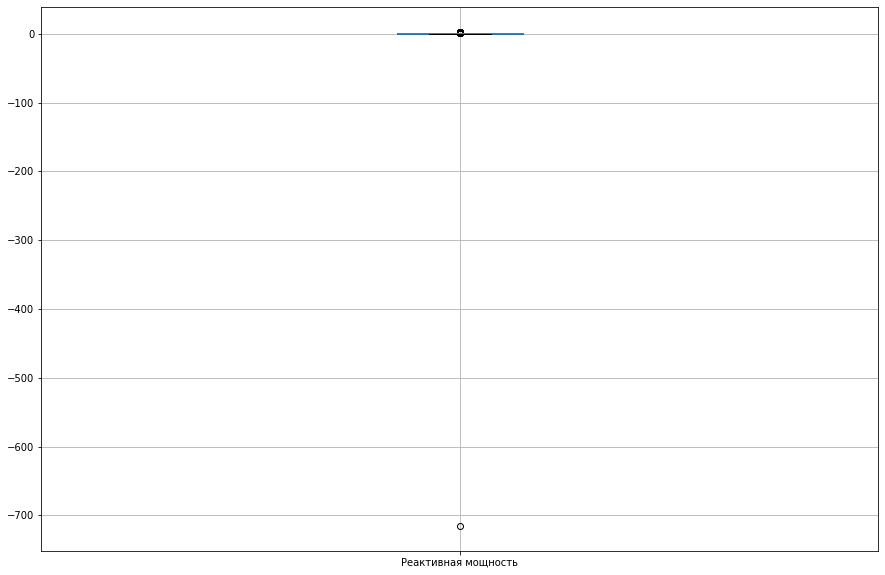

In [9]:
data_arc.boxplot(column=['Реактивная мощность'], figsize=(15,10))

## data_bulk.csv — данные о подаче сыпучих материалов (объём);

Выгрузка и изучение данных о подаче сыпучих материалов (объём).

In [10]:
try:  
    data_bulk = pd.read_csv('C:/projects/final/data_bulk.csv')
except OSError as e:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(data_bulk.head())
display(data_bulk.info())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

Столбцы `Bulk 1 - Bulk 15` - объем конкрентного сыпучего материала.

NaN - пропуски говорят о том, что это вещество не добавлялось.


In [11]:
display(data_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [12]:
def hist(data_bulk):
    plt.figure(figsize=[15,10])
    plt.hist(data_bulk, bins=100)
    plt.title(column);
    plt.xlabel("Bulk");
    plt.ylabel("Количество значений");

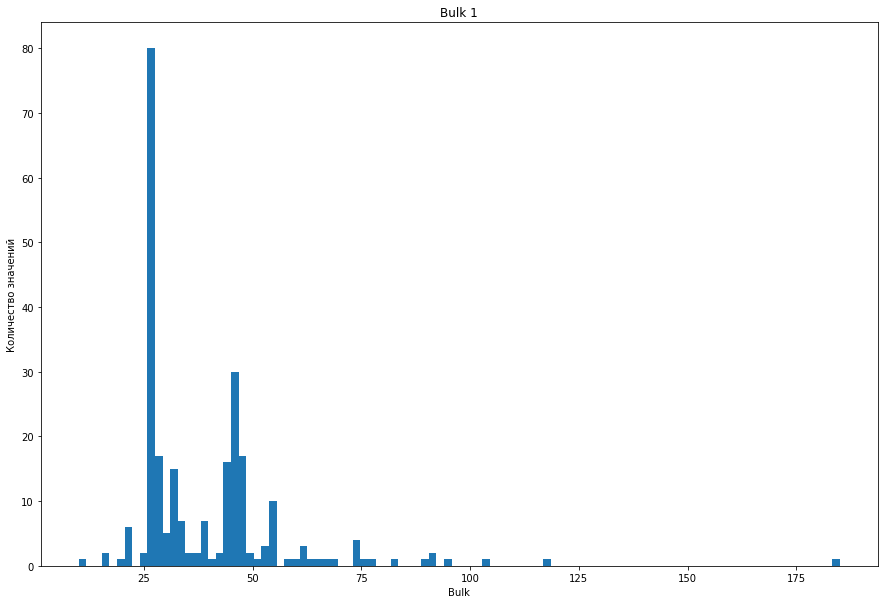

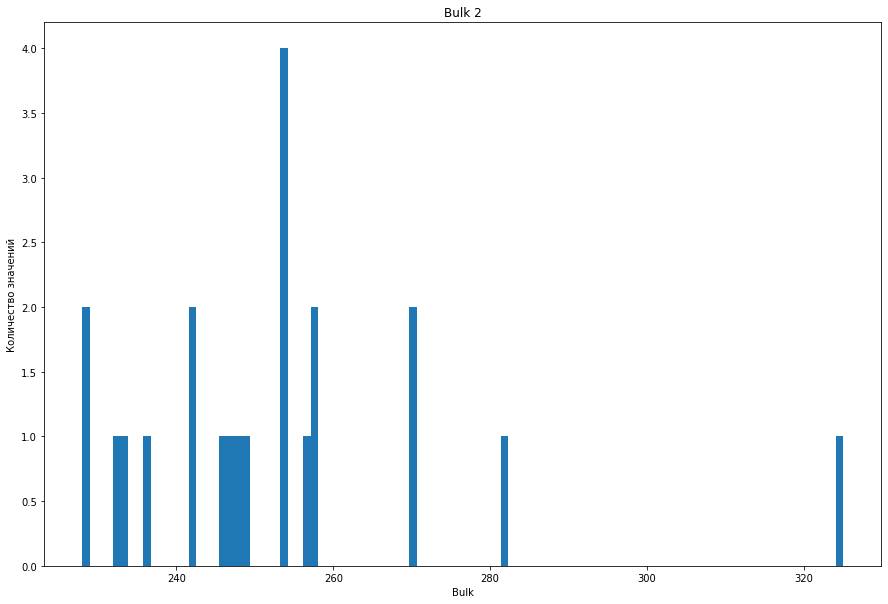

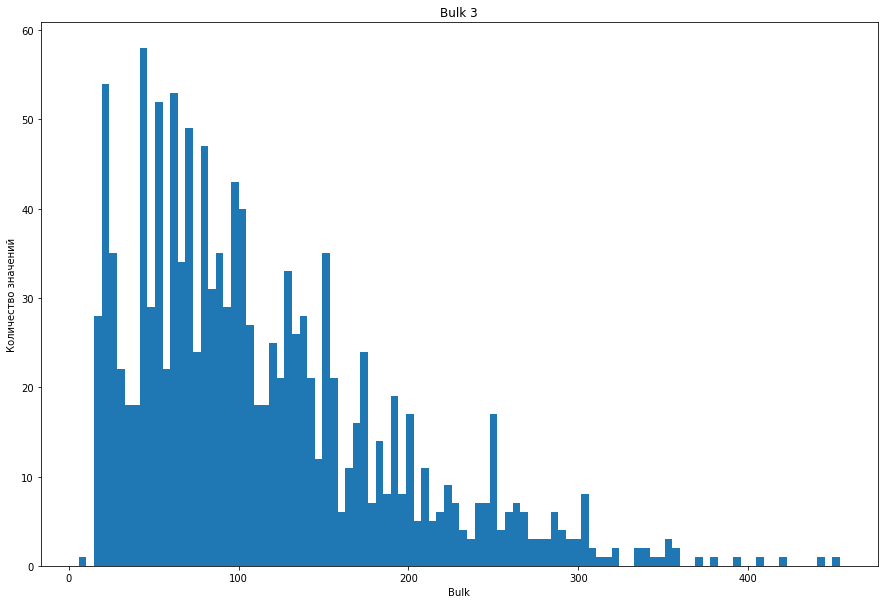

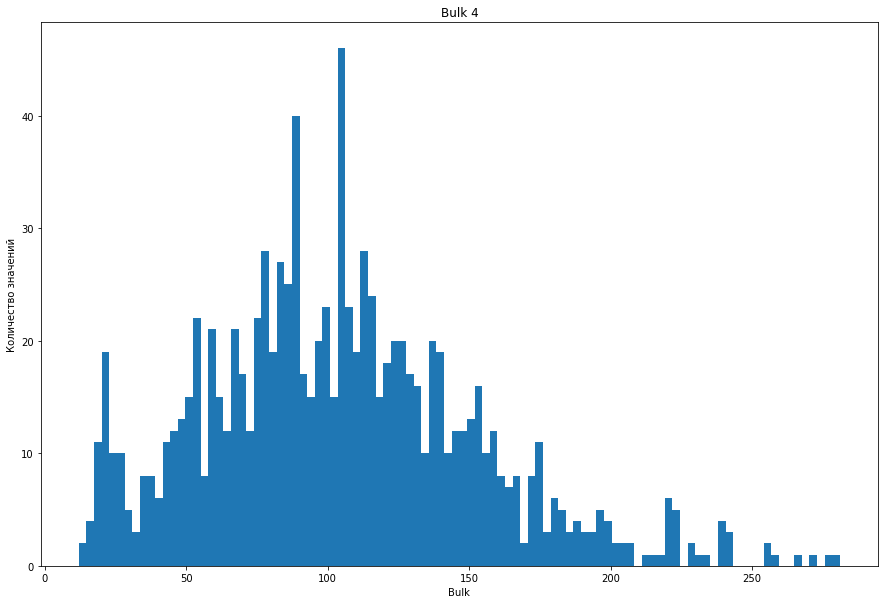

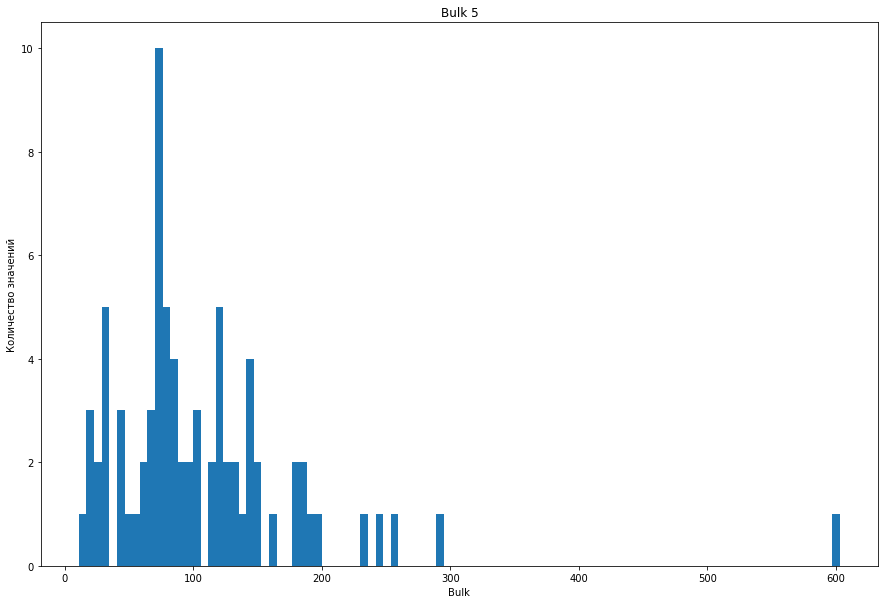

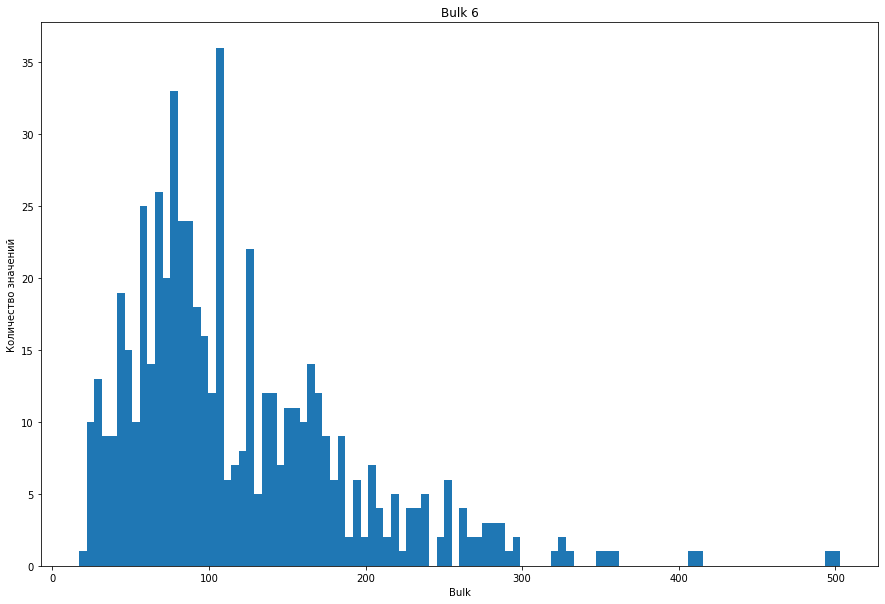

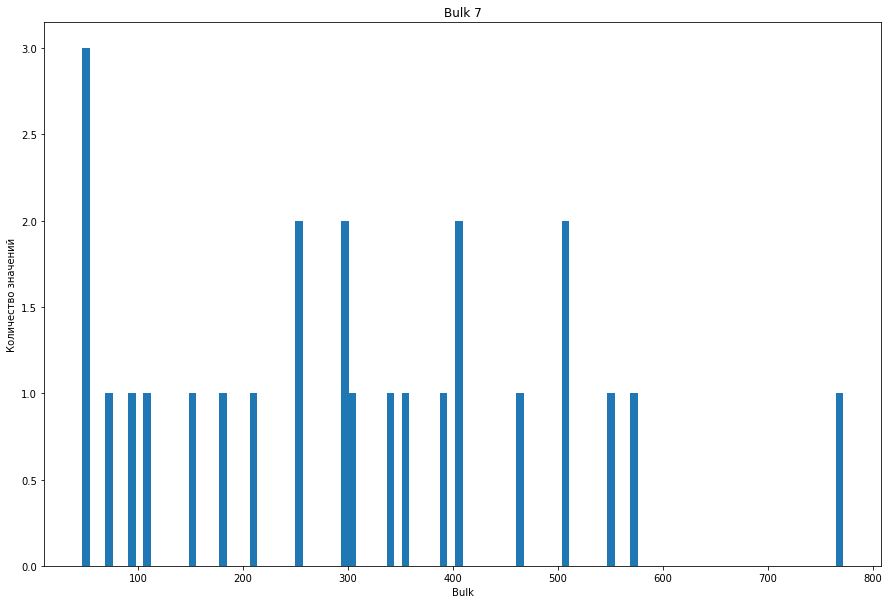

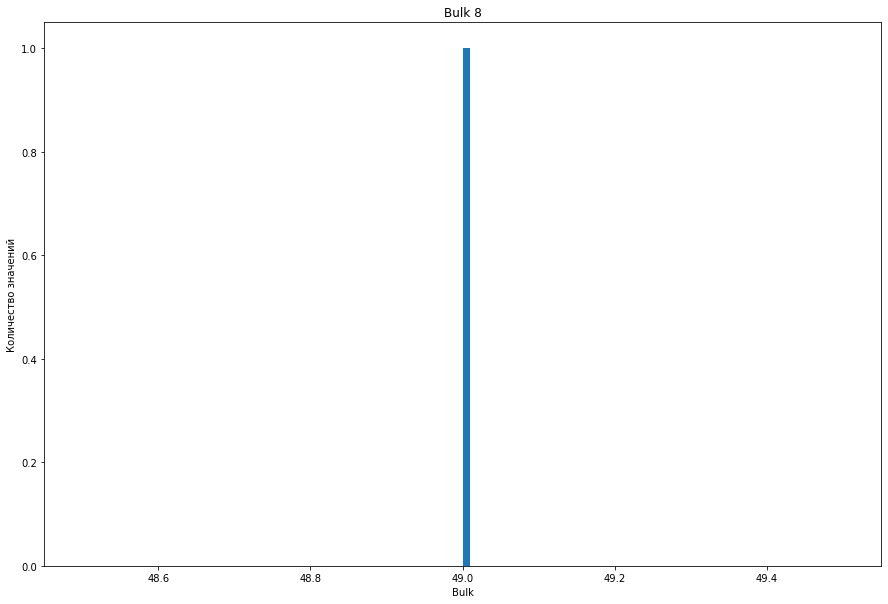

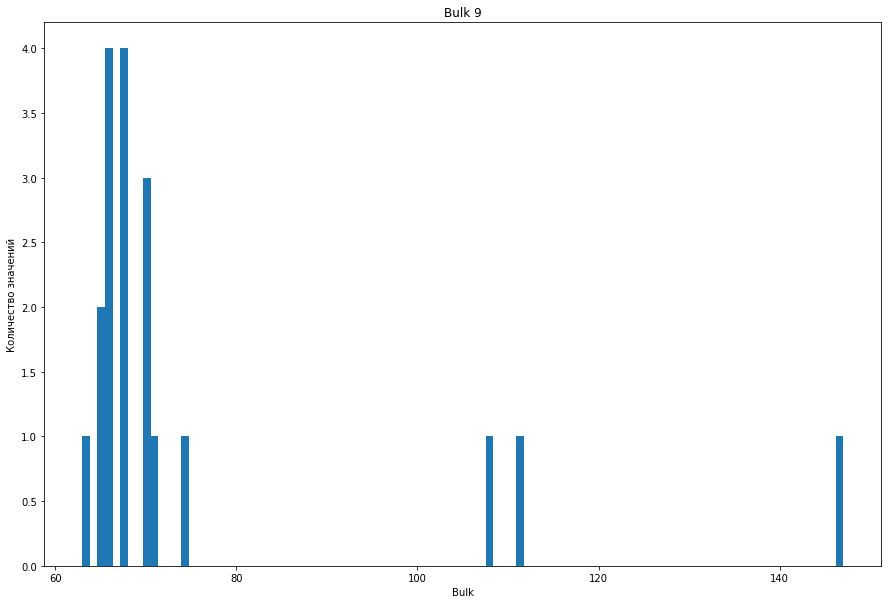

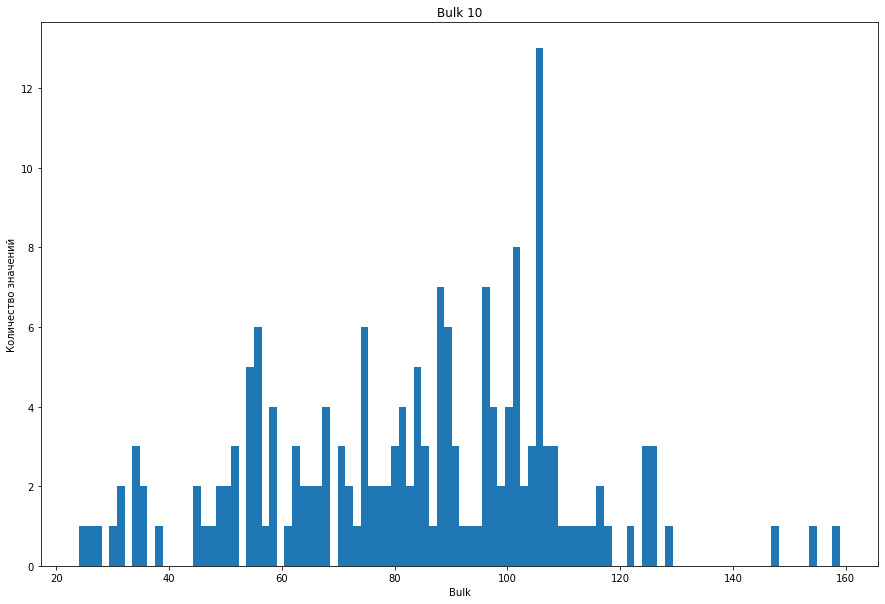

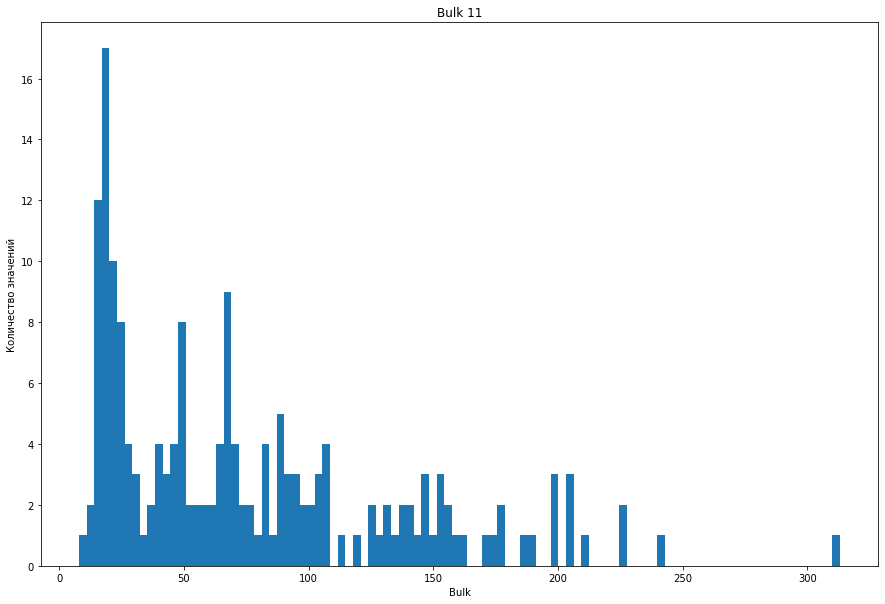

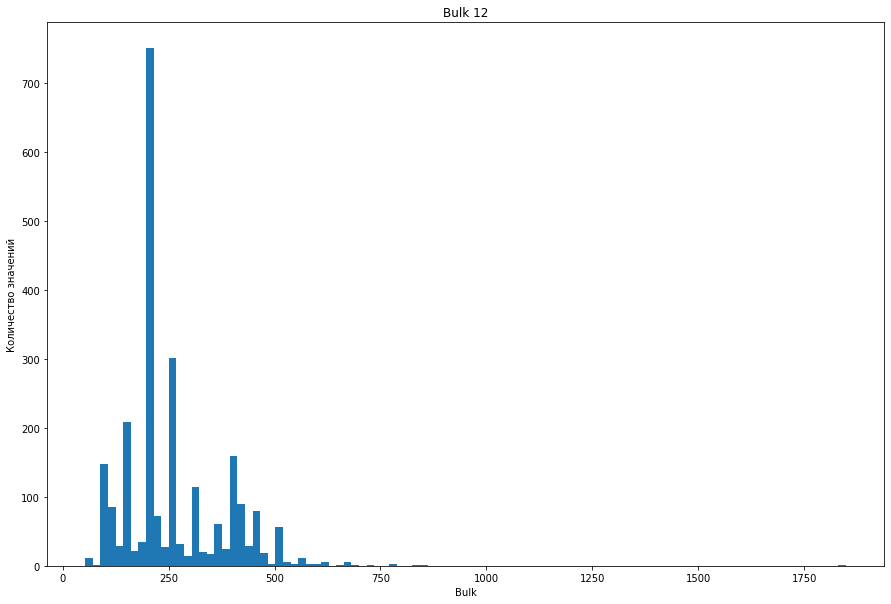

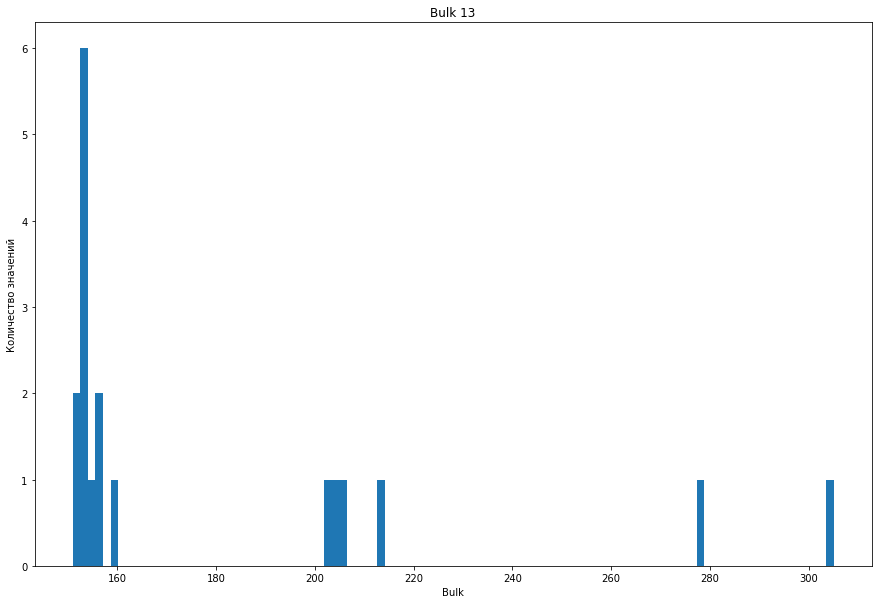

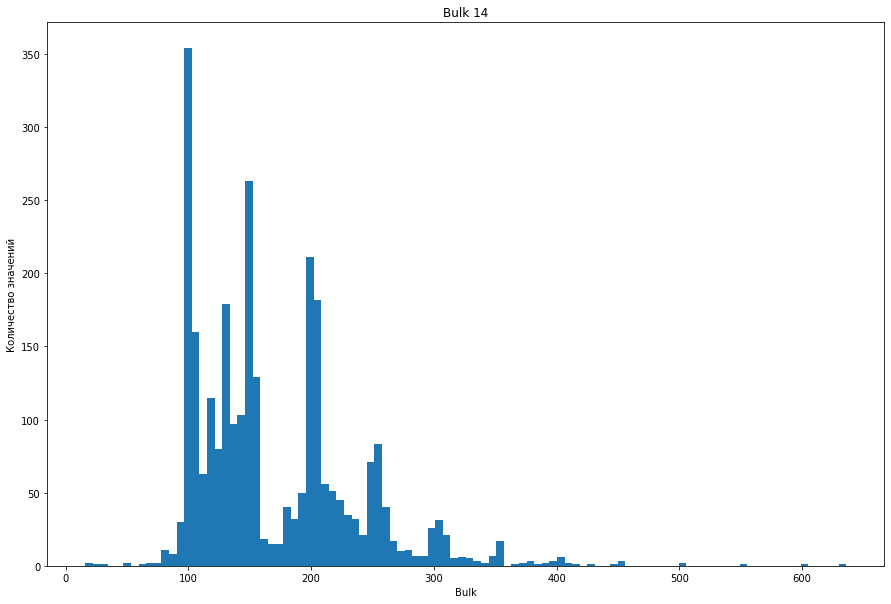

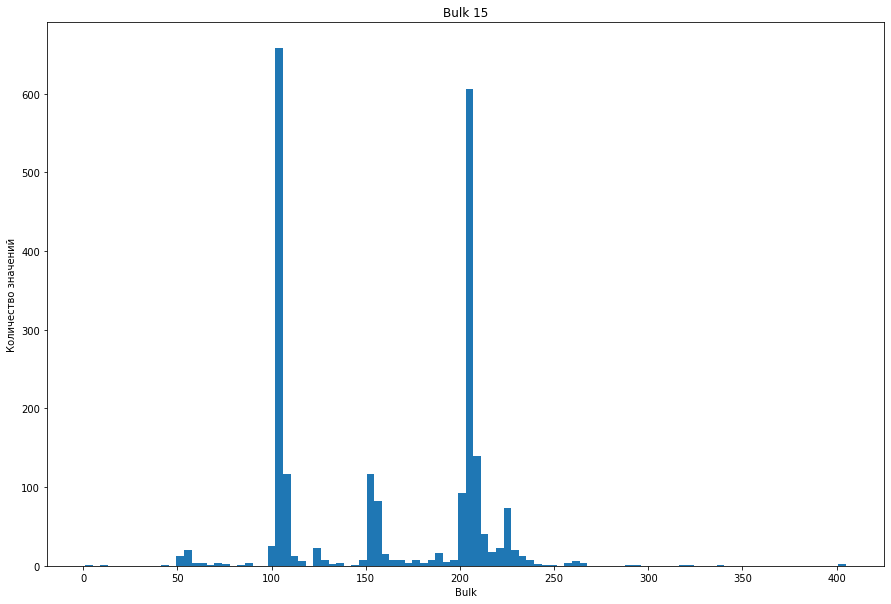

In [13]:
for column in data_bulk.columns:
    if column[0] == 'B':
        hist(data_bulk[column])

**Вывод**

- Столбцы `Bulk 1 - Bulk 15` имеют выбивающиеся значения и пропуски.
- На этапе предобратки найти общий обьем сыпучих материалов чтобы скомпановать данные для каждого ключа по дной строке.

## data_bulk_time.csv — данные о подаче сыпучих материалов (время);

Выгрузка и изучение данных о подаче сыпучих материалов (время).

In [14]:
try:  
    data_bulk_time = pd.read_csv('C:/projects/final/data_bulk_time.csv')
except OSError as e:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(data_bulk_time.head())
display(data_bulk_time.info())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

Столбцы `Bulk 1 - Bulk 15` - дата подачи конкрентного сыпучего материала.

NaN - пропуски говорят о том, что это вещество не добавлялось.

**Вывод**

- Столбцы `Bulk 1 - Bulk 15` имеют пропуски, которые говорят о том, что веществео не добавлялось.
- На этапе предобратки проверить данные на адекватность , т.к. есть сложности со снтяием точного времени.

## data_gas.csv — данные о продувке сплава газом;

Выгрузка и изучение данных о продувке сплава газом.

In [15]:
try:  
    data_gas = pd.read_csv('C:/projects/final/data_gas.csv')
except OSError as e:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(data_gas.head())
display(data_gas.info())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

`Газ 1` - количество газа.

Пропуски отсутствуют.
Вывод дискрайба и гистограммы.

In [16]:
display(data_gas.describe())

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


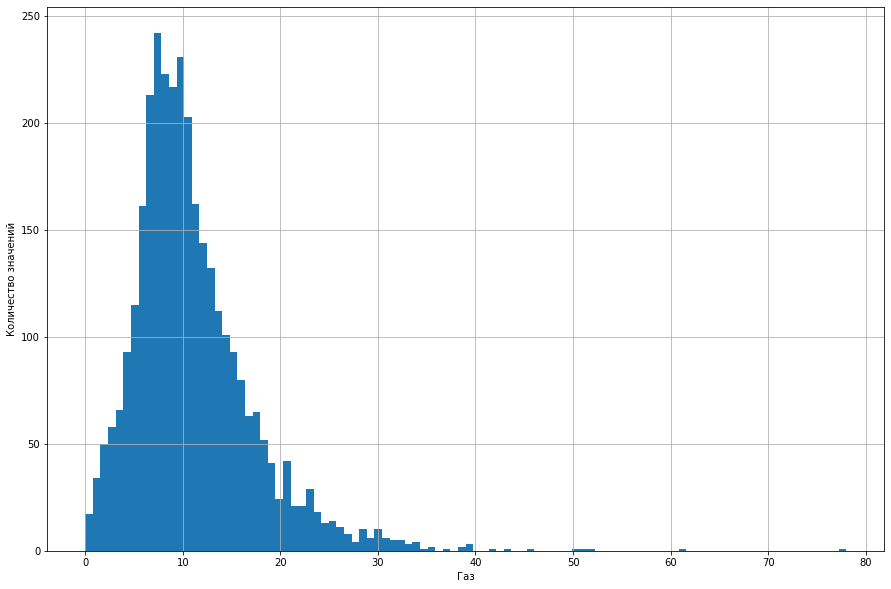

In [17]:
data_gas["Газ 1"].hist(bins=100, figsize=(15,10));
plt.xlabel("Газ");
plt.ylabel("Количество значений");

**Вывод**

- Столбец `Газ 1` имеют выбивающиеся значения, необходимо проверить.

<font color='steelblue'><b>Комментарий тимлида v2</b></font><br>
<font color='green'> ✔️ Всё верно.</font>

## data_temp.csv — результаты измерения температуры;

Выгрузка и изучение результатов измерения температуры;

In [18]:
try:  
    data_temp = pd.read_csv('C:/projects/final/data_temp.csv')
except OSError as e:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(data_temp.head())
display(data_temp.info())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

`Время замера` - время замера температуры

`Температура` - ключевой признак - конечная температура стали.

Вывод дискрайба и гистограммы.

In [19]:
display(data_temp.describe())

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


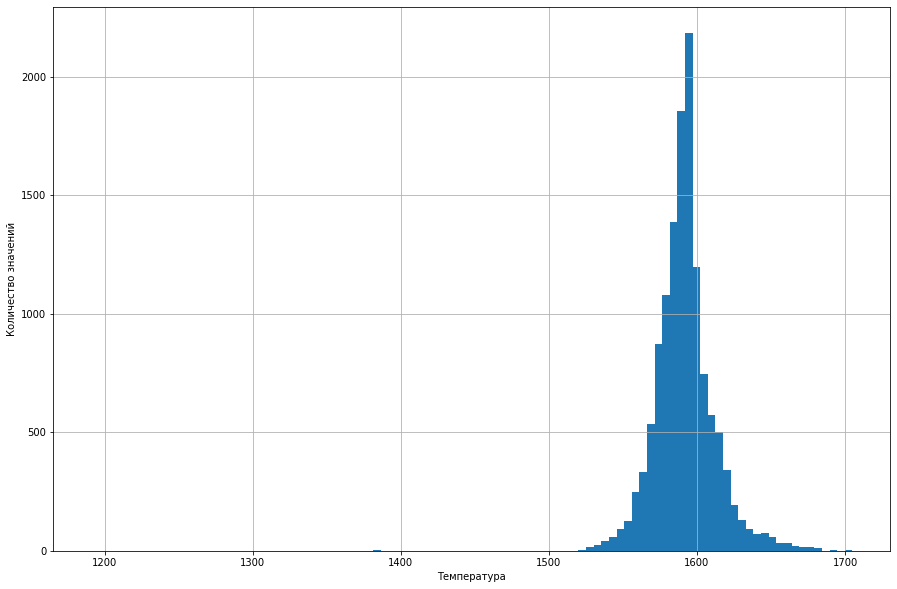

In [20]:
data_temp["Температура"].hist(bins=100, figsize=(15,10));
plt.xlabel("Температура");
plt.ylabel("Количество значений");

**Вывод**

- Столбец `Температура` содержит значения ниже 1500 градусов удалить их ключи.
- Таблицу привести к виду начальный  и конечный замер температуры.



## data_wire.csv — данные о проволочных материалах (объём);

Выгрузка и изучение данных о проволочных материалах (объём).

In [21]:
try:  
    data_wire = pd.read_csv('C:/projects/final/data_wire.csv')
except OSError as e:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(data_wire.head())
display(data_wire.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

`Wire 1 - Wire 9` - объем конкрентного проволочного материала.

NaN - пропуски говорят о том, что этот материал не добавлялся.


In [22]:
display(data_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [23]:
def hist(data_wire):
    plt.figure(figsize=[15,10])
    plt.hist(data_wire, bins=100)
    plt.title(column);
    plt.xlabel("Wire");
    plt.ylabel("Количество значений");

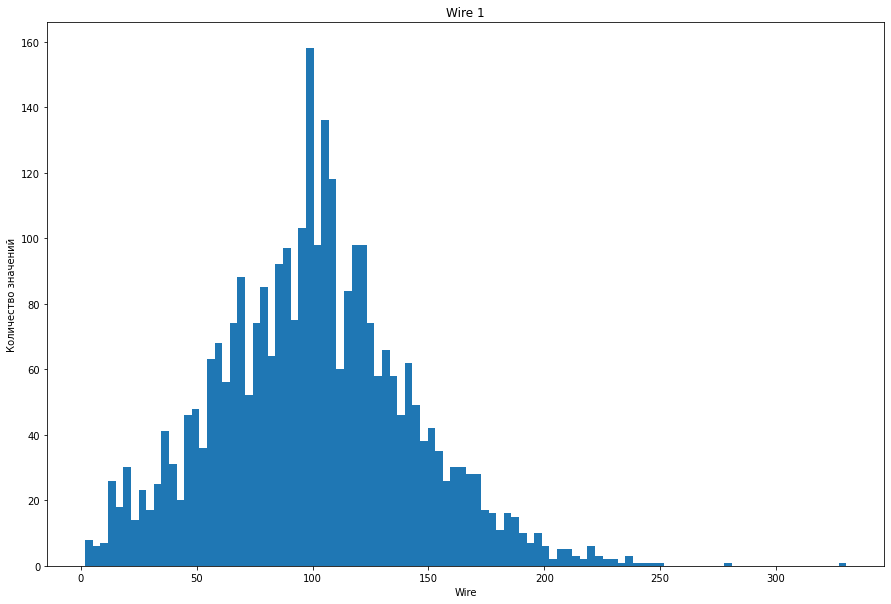

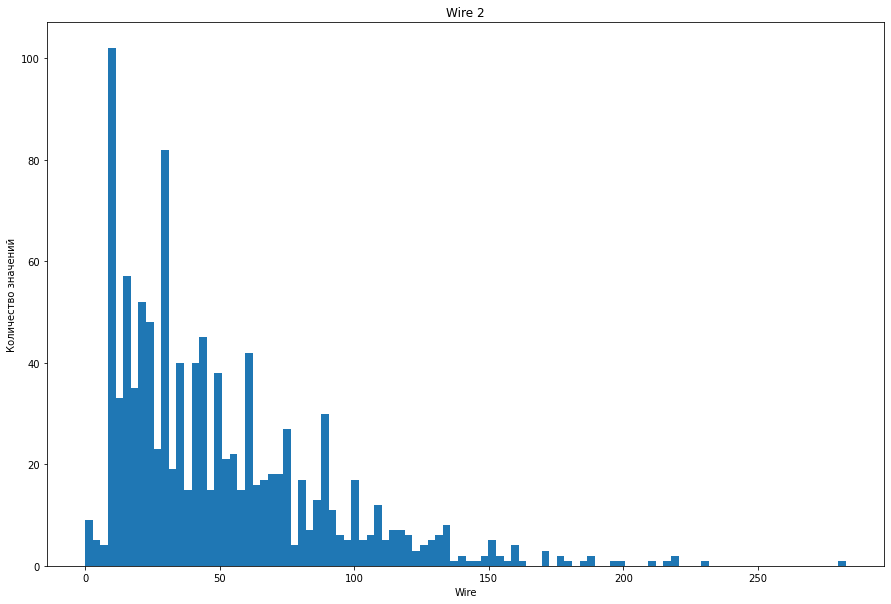

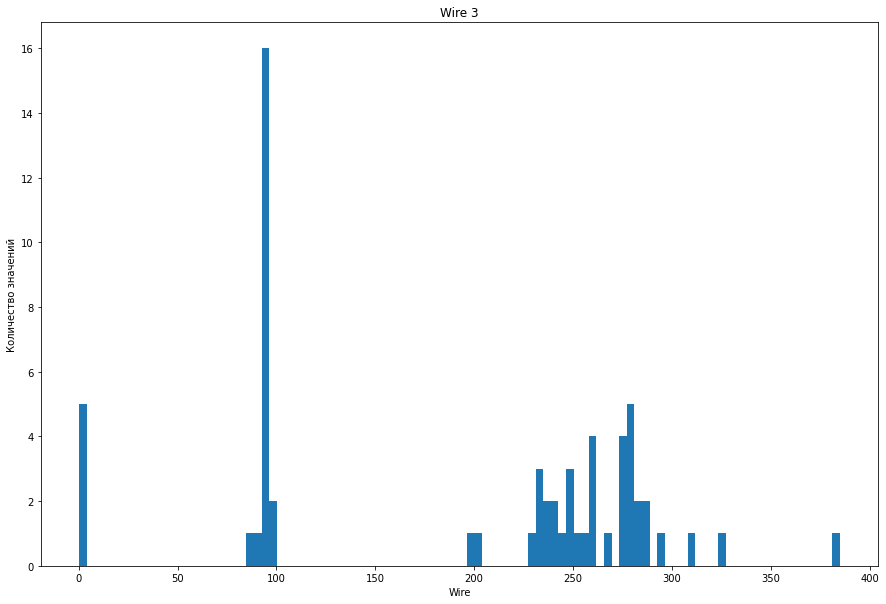

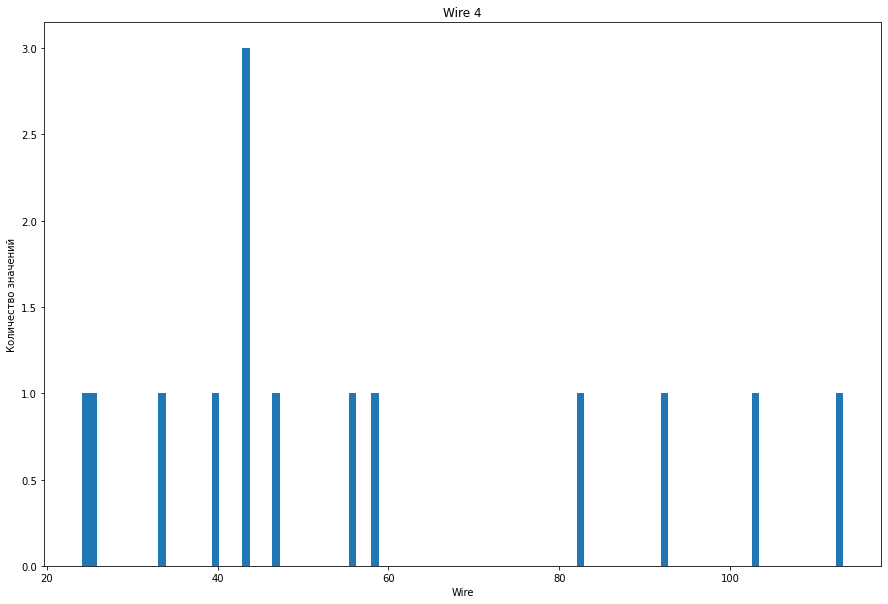

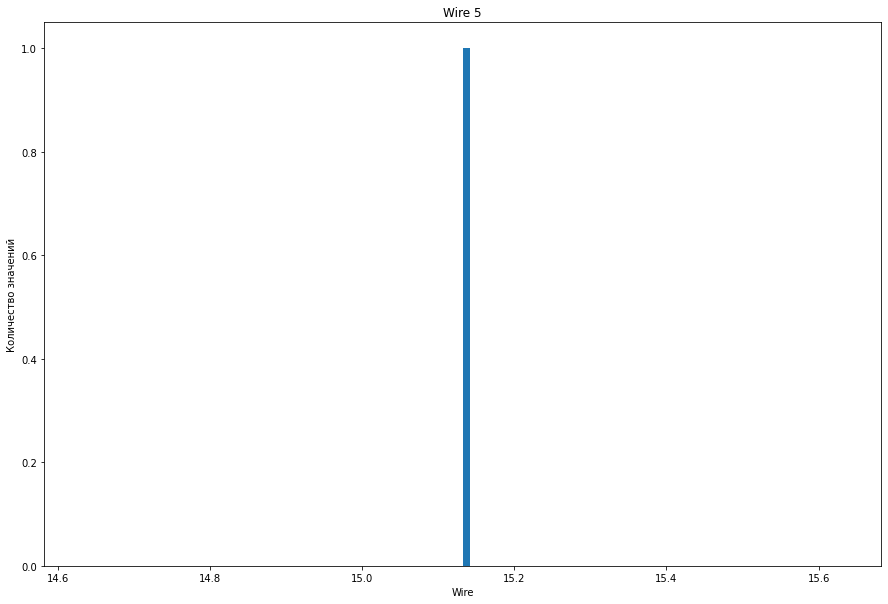

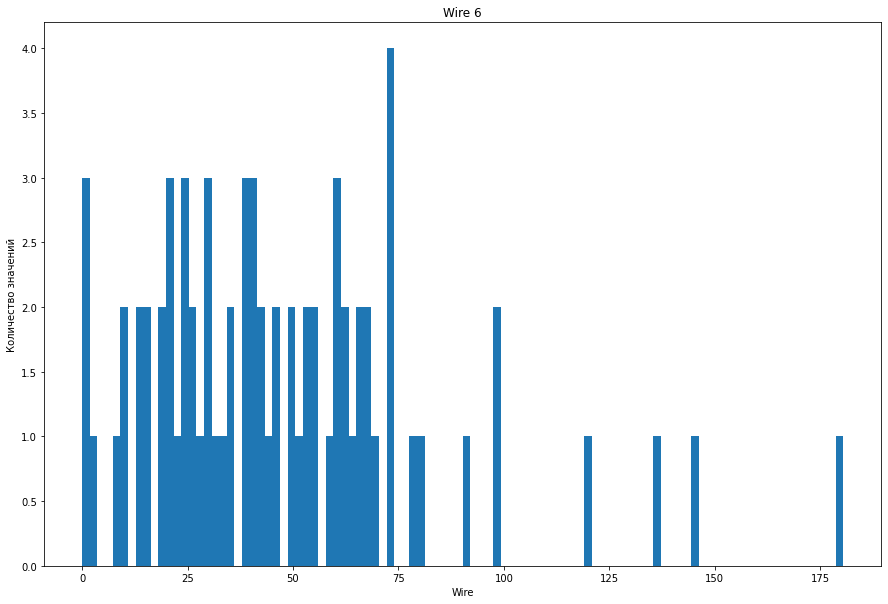

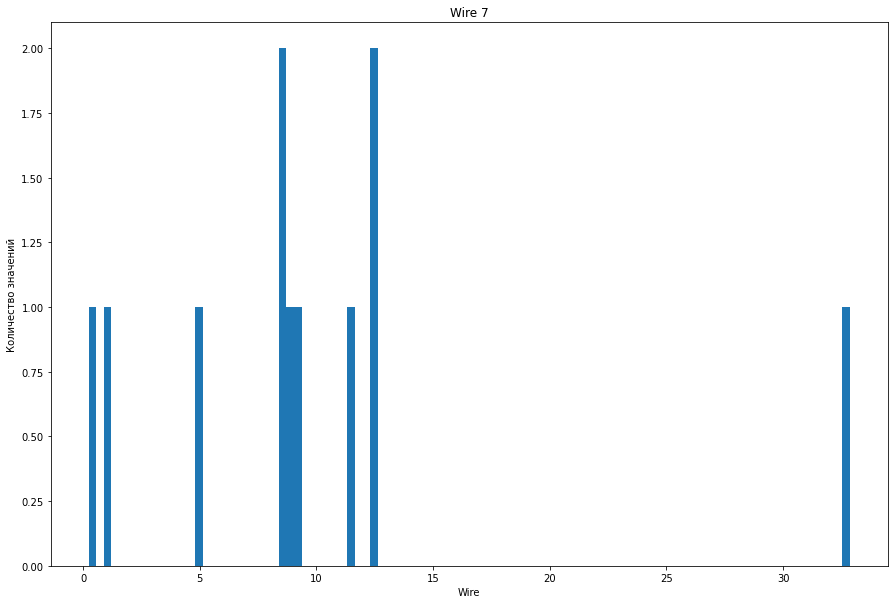

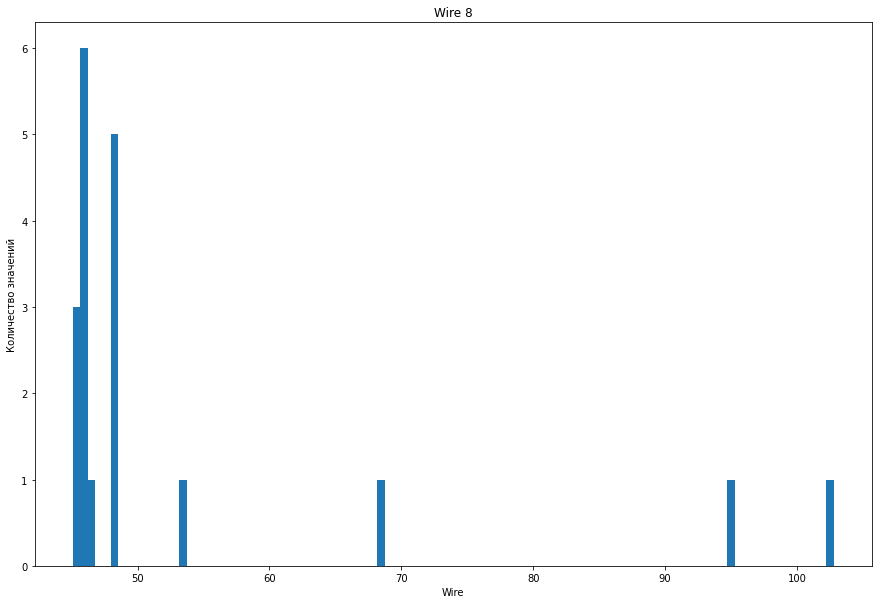

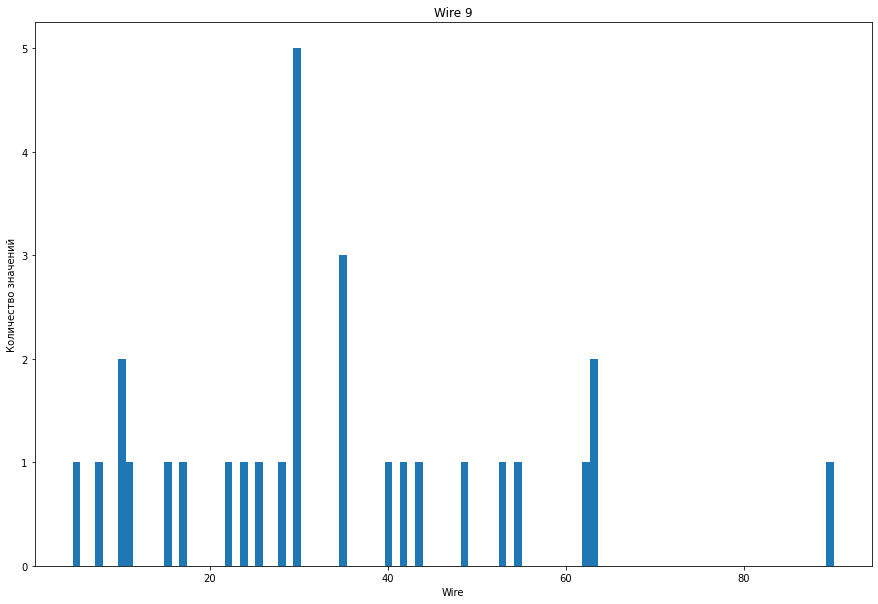

In [24]:
for column in data_wire.columns:
    if column[0] == 'W':
        hist(data_wire[column])

**Вывод**

- Столбцы `Wire 1 - Wire 9` имеют пропуски и выбивающиеся значения.
- На этапе предобратки найти общий обьем проволочных материалов чтобы скомпановать данные для каждого ключа по дной строке.

## data_wire_time.csv — данные о проволочных материалах (время).

Выгрузка и изучение данных о проволочных материалах (время).

In [25]:
try:  
    data_wire_time = pd.read_csv('C:/projects/final/data_wire_time.csv')
except OSError as e:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(data_wire_time.head())
display(data_wire_time.info())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

**Таблица содержит следующие столбцы**: 
<br>

`key`- номер партии;

`Wire 1 - Wire 9` - дата подачи конкрентного проволочного материала.

NaN - пропуски говорят о том, что этот материал не добавлялся.


**Вывод**

- Столбцы `Wire 1-Wire 9` имеют большое количество пропусков
- На этапе предобратки проверить данные на адекватность , т.к. есть сложности со снтяием точного времени.

## Вывод по изучению данных

Изучив предоставление данные можно сказать следующее:

1. В столбцах таблицах имеются пропуски.
2. В таблицах разное количество уникальных key.
3. Не все данные соотвествуют нужному типу данных, целые числые в формет float.
4. Количество записей у одной партии для каждой таблицы может различаться, поэтому необходимо добавить новые признаки и скомпоновать данные по уникальным ключам, которые содержатся во всех таблицах.
5. Аномальный выбро реактивной мощности - удалить.
6. ДАнные о температуре ниже 1500 отсеить.
7. Необходимо проверить выбивающиеся значения.


# Предобработка данных

Добавление функции для вывода первых и последних 5 значений.

In [26]:
def table(data, x=5):
    display(data.head(x))
    display(data.tail(x))

## Данные об электродах

Удаление ключа в записях которого содержится отрицательное значение в столбце `Реактивная мощность`.

In [27]:
display(data_arc.loc[data_arc["Реактивная мощность"] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [28]:
display(data_arc.loc[data_arc["key"] == 2116])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Удаление ключа 2116

In [29]:
data_arc = data_arc.loc[data_arc['key'] != 2116]

Проверка после удаления.

In [30]:
display(data_arc.loc[data_arc["key"] == 2116])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


**Длительность нагрева**

In [31]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format="%Y-%m-%d %H:%M:%S")
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format="%Y-%m-%d %H:%M:%S")

Проверка.

In [32]:
display(data_arc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


None

Добавление столбца `Продолжительность нагрева дугой` 

In [33]:
data_arc['Продолжительность нагрева дугой'] = (data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой']).dt.seconds
table(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,81


In [34]:
display(data_arc['Продолжительность нагрева дугой'].describe())

count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Продолжительность нагрева дугой, dtype: float64

<AxesSubplot:>

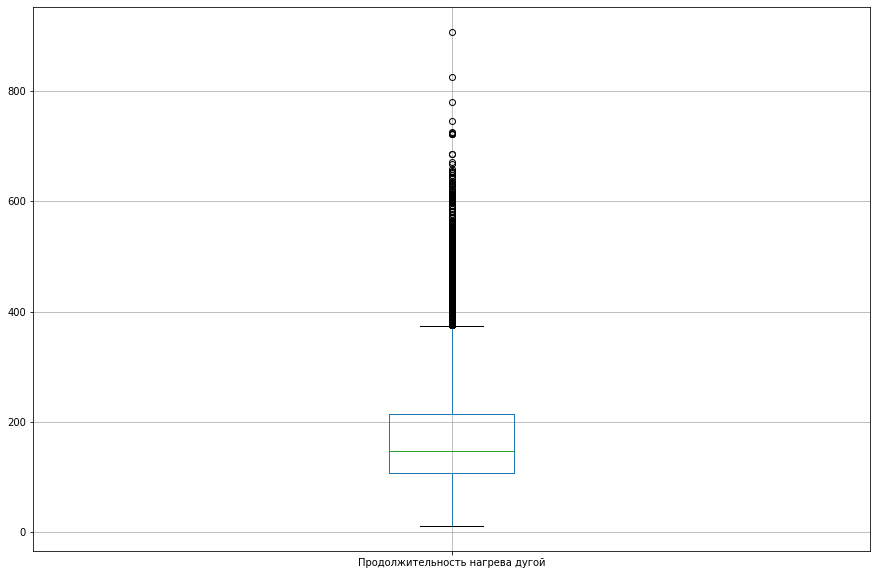

In [35]:
data_arc.boxplot(column=['Продолжительность нагрева дугой'], figsize=(15,10))

Проверка значение 907 секунд.

In [36]:
display(data_arc.loc[data_arc['Продолжительность нагрева дугой'] == 907])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.731596,2.676388,907


In [37]:
display(data_bulk.loc[data_bulk['key'] == 1689])
display(data_wire.loc[data_wire['key'] == 1689])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1629,1689,NaN,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,NaN,733.0,305.0,248.0,224.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1609,1689,187.153206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Длительность нагрева 15 минут вполне возможна, так как использовался большой объем добавок.

**Полная мощность**

Формула расчета полной мощности:

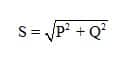

In [38]:
display(Image('https://www.asutpp.ru/wp-content/uploads/2020/03/summarnaya-moshhnost.jpg'))

где: P — активная мощность, Q — реактивная мощность

Исходя из формулы получим следующее:

In [39]:
data_arc['Полная мощность'] = np.sqrt((data_arc['Активная мощность'])**2 + (data_arc['Реактивная мощность'])**2)
table(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,0.264489
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,81,0.364260


In [40]:
display(data_arc['Полная мощность'].describe())

count    14872.000000
mean         0.838827
std          0.509882
min          0.036664
25%          0.495346
50%          0.694961
75%          1.066975
max          4.592152
Name: Полная мощность, dtype: float64

<AxesSubplot:>

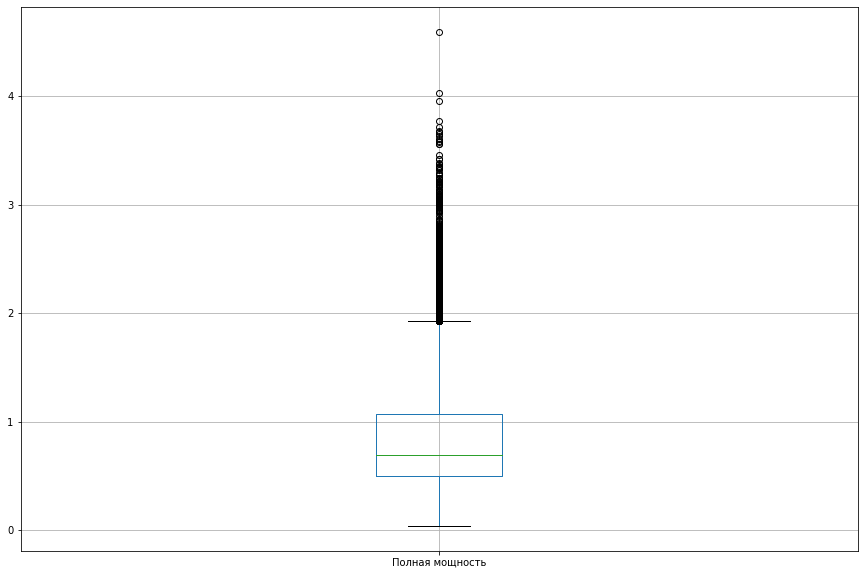

In [41]:
data_arc.boxplot(column=['Полная мощность'], figsize=(15,10))

Выбросы схожи с выбросами по длительности нагрева, что логично.

Сгрупиируем данные по одному ключу.

In [42]:
data_arc_1 = data_arc.groupby("key").agg({'Начало нагрева дугой':'first',
                                        'Конец нагрева дугой':'last',
                                        "Активная мощность":"mean",
                                        "Реактивная мощность":"mean",
                                        "Продолжительность нагрева дугой":"sum",
                                        "Полная мощность":"mean"}).reset_index()

In [43]:
table(data_arc_1)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098,1.165279
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811,0.912304
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,655,0.597907
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,741,0.953741
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,869,1.008939


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность
3208,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,909,0.968996
3209,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,546,0.898847
3210,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,1216,0.701485
3211,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,0.596817,0.496653,839,0.778371
3212,3241,2019-09-01 03:58:58,2019-09-01 04:36:08,0.494289,0.339240,659,0.599903


Проверка

In [44]:
display(data_arc_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   key                              3213 non-null   int64         
 1   Начало нагрева дугой             3213 non-null   datetime64[ns]
 2   Конец нагрева дугой              3213 non-null   datetime64[ns]
 3   Активная мощность                3213 non-null   float64       
 4   Реактивная мощность              3213 non-null   float64       
 5   Продолжительность нагрева дугой  3213 non-null   int64         
 6   Полная мощность                  3213 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 175.8 KB


None

In [45]:
display(data_arc['key'].unique().shape[0])

3213

Количество уникальных значений и строк в получившейся таблице совпадает.

Необходимо убедиться, что конец нагрева дугой выполнялся до конечного замера температуры.
Для этого создадим таблицу, которая будет содержать время замера температуры по каждому ключу.

In [46]:
data_temp_1 = copy.deepcopy(data_temp)

In [47]:
data_temp_1['Время замера'] = pd.to_datetime(data_temp_1['Время замера'], format="%Y-%m-%d %H:%M:%S")

In [48]:
data_temp_1 = data_temp_1.groupby("key").agg({"Время замера":"last"}).reset_index()

In [49]:
table(data_temp_1)

,key,Время замера
0,1,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01


,key,Время замера
3211,3237,2019-08-31 23:05:43
3212,3238,2019-08-31 23:43:00
3213,3239,2019-09-01 02:24:15
3214,3240,2019-09-01 03:35:16
3215,3241,2019-09-01 04:38:08


Соединение двух таблиц.

In [50]:
data_arc_1 = pd.merge(data_arc_1, data_temp_1, how="inner", on=["key"])

In [51]:
table(data_arc_1)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098,1.165279,2019-05-03 11:30:39
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811,0.912304,2019-05-03 11:59:12
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,655,0.597907,2019-05-03 12:34:57
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,741,0.953741,2019-05-03 12:59:25
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,869,1.008939,2019-05-03 13:36:01


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера
3208,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,909,0.968996,2019-08-31 23:05:43
3209,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,546,0.898847,2019-08-31 23:43:00
3210,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,1216,0.701485,2019-09-01 02:24:15
3211,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,0.596817,0.496653,839,0.778371,2019-09-01 03:35:16
3212,3241,2019-09-01 03:58:58,2019-09-01 04:36:08,0.494289,0.339240,659,0.599903,2019-09-01 04:38:08


In [52]:
time_ark = data_arc_1.query('`Время замера` < `Конец нагрева дугой`')

In [53]:
table(time_ark)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера
10,11,2019-05-03 16:49:14,2019-05-03 17:29:07,0.459502,0.341652,627,0.572663,2019-05-03 17:27:23
37,38,2019-05-04 16:03:36,2019-05-04 16:27:24,0.563758,0.390075,647,0.686279,2019-05-04 16:26:37
40,43,2019-05-04 20:15:41,2019-05-04 20:49:31,0.537507,0.370051,852,0.652756,2019-05-04 20:48:10
48,51,2019-05-05 05:45:24,2019-05-05 06:11:30,1.421179,0.956932,1293,1.713343,2019-05-05 06:10:21
61,64,2019-05-05 16:30:48,2019-05-05 17:28:20,0.599466,0.413482,1037,0.728384,2019-05-05 17:26:46


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера
3176,3204,2019-08-31 00:07:52,2019-08-31 00:32:40,0.535834,0.529906,749,0.759150,2019-08-31 00:30:47
3180,3209,2019-08-31 02:17:45,2019-08-31 02:37:25,0.613383,0.468384,807,0.772005,2019-08-31 02:36:07
3182,3211,2019-08-31 04:28:45,2019-08-31 04:51:19,0.657032,0.467886,667,0.806769,2019-08-31 04:49:47
3183,3212,2019-08-31 06:13:29,2019-08-31 06:21:55,0.417245,0.295013,344,0.511014,2019-08-31 06:20:55
3187,3216,2019-08-31 06:28:11,2019-08-31 06:46:38,0.295933,0.331317,464,0.444782,2019-08-31 06:44:33


Удаление из таблицы данных из "будущего".

In [54]:
ark_key_list = time_ark['key'].to_list()
data_arc = data_arc.query('key not in @ark_key_list')

In [55]:
data_arc.shape[0]

14014

In [56]:
data_arc_1 = data_arc_1.query('key not in @ark_key_list')

In [57]:
data_arc_1.shape[0]

3044

Добавим в таблицу `data_arc_1` признак - количество измерений на каждый ключ из таблицы `data_arc`.

In [58]:
ark_key_list_2 = data_arc.groupby('key')['Конец нагрева дугой'].nunique()

In [59]:
ark_key_list_2 = ark_key_list_2.to_frame()

In [60]:
ark_key_list_2.rename(columns={'Конец нагрева дугой': 'Количество нагревов'}, inplace=True)

In [61]:
data_arc_1 = pd.merge(data_arc_1, ark_key_list_2, how="left", on=["key"])

In [62]:
table(data_arc_1)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера,Количество нагревов
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098,1.165279,2019-05-03 11:30:39,5
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811,0.912304,2019-05-03 11:59:12,4
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,655,0.597907,2019-05-03 12:34:57,5
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,741,0.953741,2019-05-03 12:59:25,4
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,869,1.008939,2019-05-03 13:36:01,4


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера,Количество нагревов
3039,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,909,0.968996,2019-08-31 23:05:43,5
3040,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,546,0.898847,2019-08-31 23:43:00,3
3041,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,1216,0.701485,2019-09-01 02:24:15,8
3042,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,0.596817,0.496653,839,0.778371,2019-09-01 03:35:16,5
3043,3241,2019-09-01 03:58:58,2019-09-01 04:36:08,0.494289,0.339240,659,0.599903,2019-09-01 04:38:08,5


Добавление новыого признака - разница между окончанием нагрева и измерением температуры.

In [63]:
data_arc_1['Продолжительность остывания'] = (data_arc_1['Время замера']-data_arc_1['Конец нагрева дугой']).dt.seconds
table(data_arc_1)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера,Количество нагревов,Продолжительность остывания
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1098,1.165279,2019-05-03 11:30:39,5,122
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,811,0.912304,2019-05-03 11:59:12,4,354
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,655,0.597907,2019-05-03 12:34:57,5,158
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,741,0.953741,2019-05-03 12:59:25,4,95
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,869,1.008939,2019-05-03 13:36:01,4,126


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Время замера,Количество нагревов,Продолжительность остывания
3039,3237,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,909,0.968996,2019-08-31 23:05:43,5,115
3040,3238,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,546,0.898847,2019-08-31 23:43:00,3,92
3041,3239,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,1216,0.701485,2019-09-01 02:24:15,8,512
3042,3240,2019-09-01 02:35:24,2019-09-01 03:34:08,0.596817,0.496653,839,0.778371,2019-09-01 03:35:16,5,68
3043,3241,2019-09-01 03:58:58,2019-09-01 04:36:08,0.494289,0.339240,659,0.599903,2019-09-01 04:38:08,5,120


Удаление лишних столбцов.

In [64]:
data_arc_1 = data_arc_1.drop(columns = ['Начало нагрева дугой', "Конец нагрева дугой", "Время замера"], axis = 1)
table(data_arc_1)

,key,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания
0,1,0.975629,0.636648,1098,1.165279,5,122
1,2,0.763150,0.499528,811,0.912304,4,354
2,3,0.505176,0.319815,655,0.597907,5,158
3,4,0.802313,0.515074,741,0.953741,4,95
4,5,0.836793,0.563161,869,1.008939,4,126


,key,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания
3039,3237,0.786493,0.565692,909,0.968996,5,115
3040,3238,0.702176,0.560394,546,0.898847,3,92
3041,3239,0.583344,0.388952,1216,0.701485,8,512
3042,3240,0.596817,0.496653,839,0.778371,5,68
3043,3241,0.494289,0.339240,659,0.599903,5,120


## Данные о подаче сыпучих материалов (объём)

In [65]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Исходя из анализа данных  таблицы `data_bulk` вещества "Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13" мало используются, поэтому чтобы не ухудшалась точность модели, удалим их.

In [66]:
data_bulk = data_bulk.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)

Проверка

In [67]:
table(data_bulk)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,NaN,43.0,NaN,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,73.0,NaN,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,34.0,NaN,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,81.0,NaN,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,78.0,NaN,NaN,NaN,NaN,203.0,151.0,152.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
3124,3237,NaN,170.0,NaN,NaN,NaN,NaN,NaN,252.0,130.0,206.0
3125,3238,NaN,126.0,NaN,NaN,NaN,NaN,NaN,254.0,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,114.0,NaN,NaN,158.0,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


Пропуски заменим на 0, данные объеденим по сумме общего объема сыпучих материалов.

In [68]:
data_bulk = data_bulk.fillna(0)

In [69]:
table(data_bulk)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,158.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


Сравним количество уникальных значений и общее количество зачений столбца `key`.

In [70]:
display(data_bulk['key'].unique().shape[0])

3129

In [71]:
display(data_bulk['key'].shape[0])

3129

Добавление столбца `All Bulk`.

In [72]:
data_bulk['All Bulk'] = data_bulk.loc[:,'Bulk 1':'Bulk 15'].sum(axis=1)

In [73]:
table(data_bulk)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,All Bulk
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,553.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,582.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,544.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,595.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,584.0


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,All Bulk
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0,758.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0,594.0
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,158.0,270.0,88.0,630.0
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,192.0,54.0,272.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,232.0


Добавление столбца - Количество используемых смесей.

In [74]:
data_bulk['Count Bulk'] = 10 - ((data_bulk == 0).astype(int).sum(axis=1))

In [75]:
table(data_bulk)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,All Bulk,Count Bulk
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0,553.0,4
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0,582.0,4
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0,544.0,4
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0,595.0,4
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0,584.0,4


,key,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,All Bulk,Count Bulk
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0,758.0,4
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0,594.0,4
3126,3239,0.0,0.0,0.0,0.0,114.0,0.0,0.0,158.0,270.0,88.0,630.0,4
3127,3240,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,192.0,54.0,272.0,3
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,232.0,2


## Данные о проволочных материалах (объём)

In [76]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Исходя из анализа данных  таблицы `data_wire` вещества "Wire 4", "Wire 5 ", "Wire 7", "Wire 8", "Wire 9"  используются мнее 50 раз, поэтому чтобы не ухудшалась точность модели, удалим их.

In [77]:
data_wire = data_wire.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

Проверка

In [78]:
table(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 6
0,1,60.059998,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 6
3076,3237,38.088959,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN


Пропуски заменим на 0, данные объеденим по сумме общего объема проволочных материалов.

In [79]:
data_wire = data_wire.fillna(0)

In [80]:
table(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 6
0,1,60.059998,0.00000,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0


,key,Wire 1,Wire 2,Wire 3,Wire 6
3076,3237,38.088959,0.0,0.0,0.0
3077,3238,56.128799,0.0,0.0,0.0
3078,3239,143.357761,0.0,0.0,0.0
3079,3240,34.070400,0.0,0.0,0.0
3080,3241,63.117595,0.0,0.0,0.0


Добавление столбца `All Wire`.

In [81]:
data_wire['All Wire'] = data_wire.loc[:,'Wire 1':'Wire 6'].sum(axis=1)

In [82]:
table(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 6,All Wire
0,1,60.059998,0.00000,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,98.352796


,key,Wire 1,Wire 2,Wire 3,Wire 6,All Wire
3076,3237,38.088959,0.0,0.0,0.0,38.088959
3077,3238,56.128799,0.0,0.0,0.0,56.128799
3078,3239,143.357761,0.0,0.0,0.0,143.357761
3079,3240,34.070400,0.0,0.0,0.0,34.070400
3080,3241,63.117595,0.0,0.0,0.0,63.117595


Добавление столбца - Количество используемых проволок.

In [83]:
data_wire['Count Wire'] = 4 - ((data_wire == 0).astype(int).sum(axis=1))

In [84]:
table(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire
0,1,60.059998,0.00000,0.0,0.0,60.059998,1
1,2,96.052315,0.00000,0.0,0.0,96.052315,1
2,3,91.160157,0.00000,0.0,0.0,91.160157,1
3,4,89.063515,0.00000,0.0,0.0,89.063515,1
4,5,89.238236,9.11456,0.0,0.0,98.352796,2


,key,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire
3076,3237,38.088959,0.0,0.0,0.0,38.088959,1
3077,3238,56.128799,0.0,0.0,0.0,56.128799,1
3078,3239,143.357761,0.0,0.0,0.0,143.357761,1
3079,3240,34.070400,0.0,0.0,0.0,34.070400,1
3080,3241,63.117595,0.0,0.0,0.0,63.117595,1


## Данные о подаче сыпучих и проволочных материалов (время) 

Удаление из таблиц `df_bulk_time` и  `df_wire_time` лишних столбцов c малоиспользуемыми материалами.

In [85]:
data_bulk_time = data_bulk_time.drop(columns = ["Bulk 2", "Bulk 7", "Bulk 8", "Bulk 9", "Bulk 13"], axis = 1)
data_wire_time = data_wire_time.drop(columns = ["Wire 4", "Wire 5", "Wire 7", "Wire 8", "Wire 9"], axis = 1)

Объединение таблиц по одинаковым ключам.

In [86]:
time = pd.merge(data_temp_1, data_bulk_time, how="inner", on=["key"])

In [87]:
time_1 = pd.merge(time, data_wire_time, how="inner", on=["key"])

In [88]:
time_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3024
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3025 non-null   int64         
 1   Время замера  3025 non-null   datetime64[ns]
 2   Bulk 1        252 non-null    object        
 3   Bulk 3        1293 non-null   object        
 4   Bulk 4        1013 non-null   object        
 5   Bulk 5        77 non-null     object        
 6   Bulk 6        572 non-null    object        
 7   Bulk 10       176 non-null    object        
 8   Bulk 11       177 non-null    object        
 9   Bulk 12       2358 non-null   object        
 10  Bulk 14       2711 non-null   object        
 11  Bulk 15       2236 non-null   object        
 12  Wire 1        3000 non-null   object        
 13  Wire 2        1051 non-null   object        
 14  Wire 3        63 non-null     object        
 15  Wire 6        73 non-null     object  

Замена типа данных

In [89]:
def time(time_1):
    for column in time_1: 
        if column[0] == 'B' or column[0] == 'W':
            time_1[column] = pd.to_datetime(time_1[column], format="%Y-%m-%d %H:%M:%S") 

In [90]:
time(time_1)

In [91]:
time_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3025 entries, 0 to 3024
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3025 non-null   int64         
 1   Время замера  3025 non-null   datetime64[ns]
 2   Bulk 1        252 non-null    datetime64[ns]
 3   Bulk 3        1293 non-null   datetime64[ns]
 4   Bulk 4        1013 non-null   datetime64[ns]
 5   Bulk 5        77 non-null     datetime64[ns]
 6   Bulk 6        572 non-null    datetime64[ns]
 7   Bulk 10       176 non-null    datetime64[ns]
 8   Bulk 11       177 non-null    datetime64[ns]
 9   Bulk 12       2358 non-null   datetime64[ns]
 10  Bulk 14       2711 non-null   datetime64[ns]
 11  Bulk 15       2236 non-null   datetime64[ns]
 12  Wire 1        3000 non-null   datetime64[ns]
 13  Wire 2        1051 non-null   datetime64[ns]
 14  Wire 3        63 non-null     datetime64[ns]
 15  Wire 6        73 non-null     datetime

Проверка столбца `Время замера` на корректность , нобходимо чтобы время в столбце было позднее чем время в столбцах `Bulk`  и `Wire`

In [92]:
table(time_1)

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6
0,1,2019-05-03 11:30:39,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT
1,2,2019-05-03 11:59:12,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT
2,3,2019-05-03 12:34:57,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT
3,4,2019-05-03 12:59:25,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,NaT,NaT,NaT
4,5,2019-05-03 13:36:01,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT


,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6
3020,3237,2019-08-31 23:05:43,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT
3021,3238,2019-08-31 23:43:00,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT
3022,3239,2019-09-01 02:24:15,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,2019-09-01 01:39:41,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT
3023,3240,2019-09-01 03:35:16,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT
3024,3241,2019-09-01 04:38:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34,2019-09-01 04:16:01,NaT,NaT,NaT


In [93]:
time_1['max_result'] = time_1.loc[:,'Время замера':'Wire 6'].max(axis = 1)

In [94]:
table(time_1)

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result
0,1,2019-05-03 11:30:39,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,NaT,NaT,NaT,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,2019-05-03 13:36:01


,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result
3020,3237,2019-08-31 23:05:43,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,2019-08-31 23:05:43
3021,3238,2019-08-31 23:43:00,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,2019-08-31 23:43:00
3022,3239,2019-09-01 02:24:15,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,2019-09-01 01:39:41,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,2019-09-01 02:24:15
3023,3240,2019-09-01 03:35:16,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,2019-09-01 03:35:16
3024,3241,2019-09-01 04:38:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34,2019-09-01 04:16:01,NaT,NaT,NaT,2019-09-01 04:38:08


Сравнение значений столбцов `max_result` и `Время замера`

In [95]:
time_1_min = time_1.query('`Время замера` < `max_result`')

In [96]:
table(time_1)

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result
0,1,2019-05-03 11:30:39,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,NaT,NaT,NaT,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,2019-05-03 13:36:01


,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result
3020,3237,2019-08-31 23:05:43,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,2019-08-31 23:05:43
3021,3238,2019-08-31 23:43:00,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,2019-08-31 23:43:00
3022,3239,2019-09-01 02:24:15,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,2019-09-01 01:39:41,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,2019-09-01 02:24:15
3023,3240,2019-09-01 03:35:16,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,2019-09-01 03:35:16
3024,3241,2019-09-01 04:38:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34,2019-09-01 04:16:01,NaT,NaT,NaT,2019-09-01 04:38:08


10 замеров некорректны - удалим их ключи из таблицы `data_arc_1`.

In [97]:
data_arc_1 = data_arc_1.query("key not in [586, 1244, 1316, 1493, 1505, 1549, 1873, 2137, 2421, 2667]")

In [98]:
display(data_arc_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3040 entries, 0 to 3043
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              3040 non-null   int64  
 1   Активная мощность                3040 non-null   float64
 2   Реактивная мощность              3040 non-null   float64
 3   Продолжительность нагрева дугой  3040 non-null   int64  
 4   Полная мощность                  3040 non-null   float64
 5   Количество нагревов              3040 non-null   int64  
 6   Продолжительность остывания      3040 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 190.0 KB


None

Проверка столбоцов на наличие слишком длительной обработки стали.

In [99]:
time_1['min_result'] = time_1.loc[:,'Время замера':'Wire 6'].min(axis = 1)

In [100]:
table(time_1)

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result,min_result
0,1,2019-05-03 11:30:39,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,2019-05-03 11:30:39,2019-05-03 11:03:52
1,2,2019-05-03 11:59:12,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,2019-05-03 11:59:12,2019-05-03 11:40:20
2,3,2019-05-03 12:34:57,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,2019-05-03 12:34:57,2019-05-03 12:09:40
3,4,2019-05-03 12:59:25,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,NaT,NaT,NaT,2019-05-03 12:59:25,2019-05-03 12:41:24
4,5,2019-05-03 13:36:01,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,2019-05-03 13:36:01,2019-05-03 13:12:56


,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result,min_result
3020,3237,2019-08-31 23:05:43,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,2019-08-31 23:05:43,2019-08-31 22:46:52
3021,3238,2019-08-31 23:43:00,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,2019-08-31 23:43:00,2019-08-31 23:33:09
3022,3239,2019-09-01 02:24:15,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,2019-09-01 01:39:41,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,2019-09-01 02:24:15,2019-09-01 01:33:25
3023,3240,2019-09-01 03:35:16,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,2019-09-01 03:35:16,2019-09-01 02:41:27
3024,3241,2019-09-01 04:38:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34,2019-09-01 04:16:01,NaT,NaT,NaT,2019-09-01 04:38:08,2019-09-01 04:05:34


In [101]:
time_1['comparison_min'] = time_1['Время замера'] - time_1['min_result']

In [102]:
table(time_1)

,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result,min_result,comparison_min
0,1,2019-05-03 11:30:39,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,2019-05-03 11:30:39,2019-05-03 11:03:52,0 days 00:26:47
1,2,2019-05-03 11:59:12,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:46:10,NaT,NaT,NaT,2019-05-03 11:59:12,2019-05-03 11:40:20,0 days 00:18:52
2,3,2019-05-03 12:34:57,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:47,NaT,NaT,NaT,2019-05-03 12:34:57,2019-05-03 12:09:40,0 days 00:25:17
3,4,2019-05-03 12:59:25,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:48:05,NaT,NaT,NaT,2019-05-03 12:59:25,2019-05-03 12:41:24,0 days 00:18:01
4,5,2019-05-03 13:36:01,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,2019-05-03 13:36:01,2019-05-03 13:12:56,0 days 00:23:05


,key,Время замера,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 6,max_result,min_result,comparison_min
3020,3237,2019-08-31 23:05:43,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,2019-08-31 23:05:43,2019-08-31 22:46:52,0 days 00:18:51
3021,3238,2019-08-31 23:43:00,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,2019-08-31 23:43:00,2019-08-31 23:33:09,0 days 00:09:51
3022,3239,2019-09-01 02:24:15,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,2019-09-01 01:39:41,2019-09-01 01:33:25,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,2019-09-01 02:24:15,2019-09-01 01:33:25,0 days 00:50:50
3023,3240,2019-09-01 03:35:16,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,2019-09-01 03:35:16,2019-09-01 02:41:27,0 days 00:53:49
3024,3241,2019-09-01 04:38:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34,2019-09-01 04:16:01,NaT,NaT,NaT,2019-09-01 04:38:08,2019-09-01 04:05:34,0 days 00:32:34


In [103]:
time_1['comparison_min'] .describe()

count                         3025
mean     0 days 00:29:00.564297520
std      0 days 00:20:15.327477769
min                0 days 00:00:00
25%                0 days 00:18:58
50%                0 days 00:24:46
75%                0 days 00:34:31
max                0 days 06:27:25
Name: comparison_min, dtype: object

Значения впорядке.

## Результаты измерения температуры

Составление таблицы из столбцов `ключ`,`первый замер температуры` и `конечный замер температуры.` 

In [104]:
data_temp_1 = data_temp.groupby("key").agg({"Время замера":"first"}).reset_index()

In [105]:
data_temp_2 = pd.merge(data_temp_1, data_temp, how="left", on=["key", 'Время замера'])

In [106]:
data_temp_2 = data_temp_2.rename(columns={"Температура": "Начальная_температура"})

In [107]:
table(data_temp_2)

,key,Время замера,Начальная_температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


,key,Время замера,Начальная_температура
3211,3237,2019-08-31 22:44:04,1569.0
3212,3238,2019-08-31 23:30:31,1584.0
3213,3239,2019-09-01 01:31:47,1598.0
3214,3240,2019-09-01 02:39:01,1617.0
3215,3241,2019-09-01 04:03:30,1586.0


In [108]:
data_temp_final = data_temp.groupby("key").agg({"Время замера":"last"}).reset_index()

In [109]:
data_temp_final_1 = pd.merge(data_temp_final, data_temp, how="left", on=["key", 'Время замера'])

In [110]:
data_temp_final_1 = data_temp_final_1.rename(columns={"Температура": "Конечная_температура"})

In [111]:
table(data_temp_final_1)

,key,Время замера,Конечная_температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


,key,Время замера,Конечная_температура
3211,3237,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 03:35:16,NaN
3215,3241,2019-09-01 04:38:08,NaN


Объединение таблиц

In [112]:
data_temp_all = pd.merge(data_temp_2, data_temp_final_1, how="inner", on=["key"])

In [113]:
table(data_temp_all)

,key,Время замера_x,Начальная_температура,Время замера_y,Конечная_температура
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


,key,Время замера_x,Начальная_температура,Время замера_y,Конечная_температура
3211,3237,2019-08-31 22:44:04,1569.0,2019-08-31 23:05:43,NaN
3212,3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:43:00,NaN
3213,3239,2019-09-01 01:31:47,1598.0,2019-09-01 02:24:15,NaN
3214,3240,2019-09-01 02:39:01,1617.0,2019-09-01 03:35:16,NaN
3215,3241,2019-09-01 04:03:30,1586.0,2019-09-01 04:38:08,NaN


Исключение из таблицы ключей чьи значения менее 1500 градусов, а также пропуски.

In [114]:
data_temp_all = data_temp_all.dropna()

In [115]:
data_temp_all_1 = data_temp_all.query('Начальная_температура > 1500 & Конечная_температура > 1500')

In [116]:
table(data_temp_all_1)

,key,Время замера_x,Начальная_температура,Время замера_y,Конечная_температура
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


,key,Время замера_x,Начальная_температура,Время замера_y,Конечная_температура
2472,2495,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2473,2496,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2474,2497,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2475,2498,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0
2476,2499,2019-08-06 02:40:25,1569.0,2019-08-06 03:00:28,1603.0


Избавление от лишних столбцов , добавление нового признака.

In [117]:
data_temp_all_1['Время замера_x'] = pd.to_datetime(data_temp_all_1['Время замера_x'], format="%Y-%m-%d %H:%M:%S")

In [118]:
data_temp_all_1['Время замера_y'] = pd.to_datetime(data_temp_all_1['Время замера_y'], format="%Y-%m-%d %H:%M:%S")

In [119]:
data_temp_all_1['Длительность замера'] = (data_temp_all_1['Время замера_y'] - data_temp_all_1['Время замера_x']).dt.seconds

In [120]:
data_temp_all_1 = data_temp_all_1.drop(columns = ["Время замера_x", "Время замера_y"], axis = 1)

In [121]:
table(data_temp_all_1)

,key,Начальная_температура,Конечная_температура,Длительность замера
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762


,key,Начальная_температура,Конечная_температура,Длительность замера
2472,2495,1570.0,1591.0,1137
2473,2496,1554.0,1591.0,1618
2474,2497,1571.0,1589.0,717
2475,2498,1591.0,1594.0,1302
2476,2499,1569.0,1603.0,1203


Удаление ключей в которых Начальная температура = Конечной температуре.

In [122]:
data_temp_all_1 = data_temp_all_1.query('Начальная_температура != Конечная_температура')

In [123]:
table(data_temp_all_1)

,key,Начальная_температура,Конечная_температура,Длительность замера
0,1,1571.0,1613.0,861
1,2,1581.0,1602.0,1305
2,3,1596.0,1599.0,1300
3,4,1601.0,1625.0,388
4,5,1576.0,1602.0,762


,key,Начальная_температура,Конечная_температура,Длительность замера
2472,2495,1570.0,1591.0,1137
2473,2496,1554.0,1591.0,1618
2474,2497,1571.0,1589.0,717
2475,2498,1591.0,1594.0,1302
2476,2499,1569.0,1603.0,1203


## Создание общей таблицы

In [124]:
data_new = pd.merge(data_arc_1,
           pd.merge(data_bulk,
           pd.merge(data_wire,
           pd.merge(data_gas, data_temp_all_1,
                                                how="inner", on=["key"]),
                                                how="inner", on=["key"]),
                                                how="inner", on=["key"]),
                                                how="inner", on=["key"])

In [125]:
table(data_new)

,key,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания,Bulk 1,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Газ 1,Начальная_температура,Конечная_температура,Длительность замера
0,1,0.975629,0.636648,1098,1.165279,5,122,0.0,0.0,43.0,...,60.059998,0.00000,0.0,0.0,60.059998,1,29.749986,1571.0,1613.0,861
1,2,0.763150,0.499528,811,0.912304,4,354,0.0,0.0,73.0,...,96.052315,0.00000,0.0,0.0,96.052315,1,12.555561,1581.0,1602.0,1305
2,3,0.505176,0.319815,655,0.597907,5,158,0.0,0.0,34.0,...,91.160157,0.00000,0.0,0.0,91.160157,1,28.554793,1596.0,1599.0,1300
3,4,0.802313,0.515074,741,0.953741,4,95,0.0,0.0,81.0,...,89.063515,0.00000,0.0,0.0,89.063515,1,18.841219,1601.0,1625.0,388
4,5,0.836793,0.563161,869,1.008939,4,126,0.0,0.0,78.0,...,89.238236,9.11456,0.0,0.0,98.352796,2,5.413692,1576.0,1602.0,762


,key,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания,Bulk 1,Bulk 3,Bulk 4,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Газ 1,Начальная_температура,Конечная_температура,Длительность замера
2161,2495,0.802673,0.590194,723,0.996717,4,209,0.0,21.0,0.0,...,89.150879,0.00000,0.0,0.0,89.150879,1,7.125735,1570.0,1591.0,1137
2162,2496,0.700511,0.468364,940,0.842839,6,380,0.0,0.0,63.0,...,114.179527,0.00000,0.0,0.0,114.179527,1,9.412616,1554.0,1591.0,1618
2163,2497,0.737460,0.617090,569,0.961672,3,185,0.0,0.0,85.0,...,94.086723,9.04800,0.0,0.0,103.134723,2,6.271699,1571.0,1589.0,717
2164,2498,0.681745,0.471086,750,0.828750,5,307,0.0,90.0,0.0,...,118.110717,0.00000,0.0,0.0,118.110717,1,14.953657,1591.0,1594.0,1302
2165,2499,1.024608,0.694466,883,1.238253,4,286,0.0,47.0,0.0,...,110.160958,50.00528,0.0,0.0,160.166238,2,11.336151,1569.0,1603.0,1203


In [126]:
display(data_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 0 to 2165
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              2166 non-null   int64  
 1   Активная мощность                2166 non-null   float64
 2   Реактивная мощность              2166 non-null   float64
 3   Продолжительность нагрева дугой  2166 non-null   int64  
 4   Полная мощность                  2166 non-null   float64
 5   Количество нагревов              2166 non-null   int64  
 6   Продолжительность остывания      2166 non-null   int64  
 7   Bulk 1                           2166 non-null   float64
 8   Bulk 3                           2166 non-null   float64
 9   Bulk 4                           2166 non-null   float64
 10  Bulk 5                           2166 non-null   float64
 11  Bulk 6                           2166 non-null   float64
 12  Bulk 10             

None

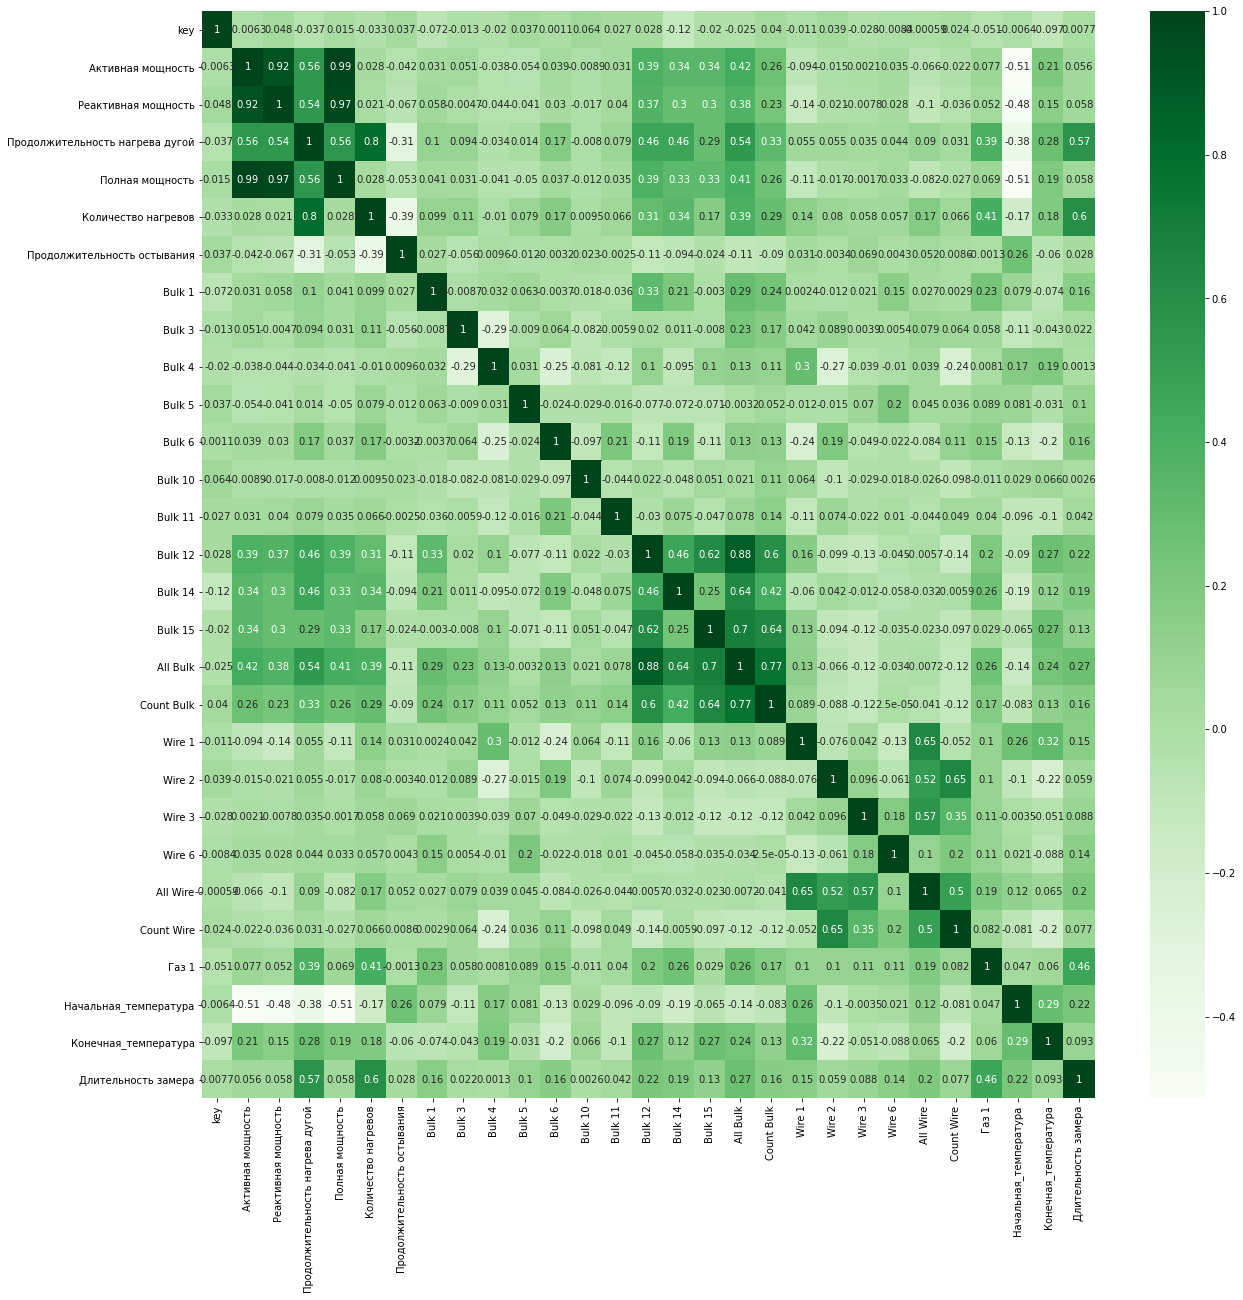

In [127]:
import seaborn as sns
corr = data_new.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

Судя по графику есть смысл оставить только полную мощность и активную мощность. Несмотря на высокую корреляцию материалов Bulk 12 и Wire 1  в таблице их оставим, т.к. они частоиспользуемые. 

In [128]:
data_new = data_new.drop(columns = ["key", "Реактивная мощность"], axis = 1)

In [129]:
table(data_new)

,Активная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Газ 1,Начальная_температура,Конечная_температура,Длительность замера
0,0.975629,1098,1.165279,5,122,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,60.059998,1,29.749986,1571.0,1613.0,861
1,0.763150,811,0.912304,4,354,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,96.052315,1,12.555561,1581.0,1602.0,1305
2,0.505176,655,0.597907,5,158,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,91.160157,1,28.554793,1596.0,1599.0,1300
3,0.802313,741,0.953741,4,95,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,89.063515,1,18.841219,1601.0,1625.0,388
4,0.836793,869,1.008939,4,126,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,98.352796,2,5.413692,1576.0,1602.0,762


,Активная мощность,Продолжительность нагрева дугой,Полная мощность,Количество нагревов,Продолжительность остывания,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Газ 1,Начальная_температура,Конечная_температура,Длительность замера
2161,0.802673,723,0.996717,4,209,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,89.150879,1,7.125735,1570.0,1591.0,1137
2162,0.700511,940,0.842839,6,380,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,114.179527,1,9.412616,1554.0,1591.0,1618
2163,0.737460,569,0.961672,3,185,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,103.134723,2,6.271699,1571.0,1589.0,717
2164,0.681745,750,0.828750,5,307,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,118.110717,1,14.953657,1591.0,1594.0,1302
2165,1.024608,883,1.238253,4,286,0.0,47.0,0.0,0.0,0.0,...,110.160958,50.00528,0.0,0.0,160.166238,2,11.336151,1569.0,1603.0,1203


## Переименование столбцов таблицы согласно стандартам

In [130]:
data_new = data_new.rename(columns={'Активная мощность': 'Active_power', 'Продолжительность нагрева дугой': 'Time_heating', 
                                    'Полная мощность':'Full_power', 'Количество нагревов' : 'Count_heatings', 
                                    'Продолжительность остывания' : 'Time_cooling_down', 'Газ 1' : 'Gas 1', 
                                    'Начальная_температура' : 'Start_temp', 'Конечная_температура' : 'Final_temp',
                                    'Длительность замера' : 'Time_sample'})

In [131]:
table(data_new)

,Active_power,Time_heating,Full_power,Count_heatings,Time_cooling_down,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Gas 1,Start_temp,Final_temp,Time_sample
0,0.975629,1098,1.165279,5,122,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,60.059998,1,29.749986,1571.0,1613.0,861
1,0.763150,811,0.912304,4,354,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,96.052315,1,12.555561,1581.0,1602.0,1305
2,0.505176,655,0.597907,5,158,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,91.160157,1,28.554793,1596.0,1599.0,1300
3,0.802313,741,0.953741,4,95,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,89.063515,1,18.841219,1601.0,1625.0,388
4,0.836793,869,1.008939,4,126,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,98.352796,2,5.413692,1576.0,1602.0,762


,Active_power,Time_heating,Full_power,Count_heatings,Time_cooling_down,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 6,All Wire,Count Wire,Gas 1,Start_temp,Final_temp,Time_sample
2161,0.802673,723,0.996717,4,209,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,89.150879,1,7.125735,1570.0,1591.0,1137
2162,0.700511,940,0.842839,6,380,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,114.179527,1,9.412616,1554.0,1591.0,1618
2163,0.737460,569,0.961672,3,185,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,103.134723,2,6.271699,1571.0,1589.0,717
2164,0.681745,750,0.828750,5,307,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,118.110717,1,14.953657,1591.0,1594.0,1302
2165,1.024608,883,1.238253,4,286,0.0,47.0,0.0,0.0,0.0,...,110.160958,50.00528,0.0,0.0,160.166238,2,11.336151,1569.0,1603.0,1203


## Вывод

Произведена предобработка данных. 

Данные подготовлены к тестированию моделей. Составлена общая таблица только с теми ключами, которые имела полные данные из всхе таблиц.
Добавлены новые признаки такие как : 
- Time_heating
- Full_power
- All Bulk
- All Wire
- Count_heatings
- Time_cooling_down	
- Count Wire
- Start_temp
- Final_temp
- Time_sample

# Обучение и тестирование моделей

Разобьем имеющиеся данные на две выборки : тренировочную и тестовую. Параметр test_size = 0.25.

In [131]:
features = data_new.drop('Final_temp', axis=1)
target = data_new['Final_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=RANDOM_STATE)

In [132]:
print("Размер тренировочной выборки:", features_train.shape[0])
print("Размер тестовой выборки:", features_test.shape[0])

Размер тренировочной выборки: 1624
Размер тестовой выборки: 542


## Обучение 

Произведем обучение след. моделей : Ridge,  Lasso, CatBoostRegressor, LGBMRegressor, XGBRegressor.  Среди них выберем лучшую.

### Ridge

In [133]:
%%time

model_Ridge = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100], 
                'solver':['auto','svd','cholesky', 'lsqr','sparse_cg'],
                'random_state':[RANDOM_STATE]}]

clf_Ridge = RandomizedSearchCV(model_Ridge, hyperparams , cv=5, scoring='neg_mean_absolute_error')
clf_Ridge.fit(features_train, target_train)
params_Ridge = clf_Ridge.best_params_
print('Best_params: ', params_Ridge)

MAE_Ridge = (clf_Ridge.best_score_) * -1
print('MAE: ', MAE_Ridge)

Best_params:  {'solver': 'auto', 'random_state': 80822, 'alpha': 0.1}
MAE:  5.839887249259192
Wall time: 563 ms


### Lasso

In [134]:
%%time

model_Lasso = linear_model.Lasso(alpha=0.1)
hyperparams = [{'fit_intercept':[True, False], 
                 'normalize':[True, False],
                  'random_state':[RANDOM_STATE]}]

clf_Lasso = RandomizedSearchCV(model_Lasso,hyperparams, cv=5, scoring='neg_mean_absolute_error')
clf_Lasso.fit(features_train, target_train)
params_Lasso = clf_Lasso.best_params_
print('Best_params: ', params_Lasso)

MAE_Lasso = (clf_Lasso.best_score_) * -1
print('MAE: ', MAE_Lasso) 

Best_params:  {'random_state': 80822, 'normalize': False, 'fit_intercept': True}
MAE:  5.997785868689728
Wall time: 667 ms


### CatBoostRegressor

In [135]:
%%time

model_CBR = CatBoostRegressor(verbose=False)
hyperparams = [{'iterations' : [100, 500, 1000],
                'depth' : [0,1,2,3,4,5] , 
                'learning_rate' : [0.1, 0.2, 0.3],
                'random_state':[RANDOM_STATE]}]

clf_CBR = RandomizedSearchCV(model_CBR, hyperparams, cv=5, scoring='neg_mean_absolute_error')
clf_CBR.fit(features_train, target_train)
params_CBR = clf_CBR.best_params_
print('Best_params: ', params_CBR)

MAE_CBR = (clf_CBR.best_score_) * -1
print('MAE: ', MAE_CBR) 

Best_params:  {'random_state': 80822, 'learning_rate': 0.1, 'iterations': 500, 'depth': 2}
MAE:  5.763988787675745
Wall time: 40.7 s


### LGBMRegressor

In [136]:
%%time

model_LGBMR = LGBMRegressor()
hyperparams = [{'num_leaves':[5, 10, 15, 20, 25, 30], 
                'learning_rate':[0.2, 0.1, 0.01],
                'n_estimators' : [50, 100, 500, 1000],
                'max_depth' : [-1, 3, 5],
                'random_state':[RANDOM_STATE]}]

clf_LGBMR = RandomizedSearchCV(model_LGBMR, hyperparams, cv=5, scoring='neg_mean_absolute_error')
clf_LGBMR.fit(features_train, target_train)
params_LGBMR = clf_LGBMR.best_params_
print('Best_params: ', params_LGBMR)

MAE_LGBMR = (clf_LGBMR.best_score_) * -1
print('MAE: ', MAE_LGBMR) 

Best_params:  {'random_state': 80822, 'num_leaves': 5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
MAE:  5.928808293130541
Wall time: 18.7 s


### XGBRegressor

In [137]:
%%time

model_XGBR = XGBRegressor()
hyperparams = [{'learning_rate':[0.3, 0.2, 0.1, 0.01],
                'max_depth' : [1, 5, 10, 20],
                'reg_alpha': [1.1, 1.2, 1.3],
                'reg_lambda': [1.1, 1.2, 1.3],
                 'random_state':[RANDOM_STATE]}]


clf_XGBR = RandomizedSearchCV(model_XGBR, hyperparams, cv=5, scoring='neg_mean_absolute_error')
clf_XGBR.fit(features_train, target_train)
params_XGBR = clf_XGBR.best_params_
print('Best_params: ', params_XGBR)

MAE_XGBR = (clf_XGBR.best_score_) * -1
print('MAE: ', MAE_XGBR) 

Best_params:  {'reg_lambda': 1.3, 'reg_alpha': 1.1, 'random_state': 80822, 'max_depth': 5, 'learning_rate': 0.1}
MAE:  5.957290327255089
Wall time: 14.1 s


### Выбор модели

Составление таблицы и выбор лучшей модели для тестирования.

In [138]:
index = ['Ridge',
         'Lasso',
         'CatBoostRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE result':[MAE_Ridge,
                     MAE_Lasso,
                     MAE_CBR,
                     MAE_LGBMR,
                     MAE_XGBR] }

result = pd.DataFrame(data=data, index=index)
display(result.sort_values(by = 'MAE result'))

,MAE result
CatBoostRegressor,5.763989
Ridge,5.839887
LGBMRegressor,5.928808
XGBRegressor,5.957290
Lasso,5.997786


Были обучены модели Ridge, Lasso, CatBoostRegressor, LGBMRegressor, XGBRegressor. 
<br>
Лучший результат `MAE` 5.763989 показала модель `CatBoostRegressor` с параметрами `'random_state': 80822, 'learning_rate': 0.1, 'iterations': 500, 'depth': 2. `

## Тестирование лучшей модели

Лучшей моделью оказалась CatBoostRegressor. Проиведем тестирование.

In [139]:
%%time

result = CatBoostRegressor(verbose=False)
result.set_params(**params_CBR)
result.fit(features_train, target_train)
target_predict = result.predict(features_test)
MAE_result = mean_absolute_error(target_predict, target_test)
print('MAE', MAE_result)

MAE 5.163579524966794
Wall time: 860 ms


In [133]:
data_new['Final_temp'].median()

1593.0

In [134]:
data_new['Final_temp'].mean()

1593.4907663896583

Создание констатной модели, по медианому значению.

In [136]:
target = data_new['Final_temp']
features = data_new.drop('Final_temp', axis=1)

target_pred_constant = pd.Series(data_new['Final_temp'].median(), index=target.index)
MAE_const = mean_absolute_error(target, target_pred_constant)

print('MAE const: ', MAE_const)

MAE const:  8.0595567867036


In [140]:
index = ['MAE_CBR_test',
         'MAE const',]
data = {'result':['5.163579524966794',
                     MAE_const] }

result = pd.DataFrame(data=data, index=index)
print(result)


                         result
MAE_CBR_test  5.163579524966794
MAE const              8.059557


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной

## Вывод

В ходе обучения и тестирования моделей данные были разделены на тренировочную и тестовую выборки.

<br>

Были обучены 5 моделей:

- Ridge
- Lasso 
- CatBoostRegressor
- LGBMRegressor
- XGBRegressor


Все вышеперечисленные модели показали хорошие результаты на тренировочной выборке.

Лучше всего показала себя модель CatBoostRegressor c MAE test = 5.763989, на которой и было произведено дальнейшее тестирование , которое дало результат MAE  = 5.163579. 


# Общий вывод

В ходе исследования над данным проектом по оптимизации происзводственным расходом металлургического комбината ООО «Так закаляем сталь» было сделано следующее:

- Произведен тщательный анализ данных (найдены: пропуски, некорректные значения, аномальные выбросы, несоответсвующий тип данных в столбцах , разное количество уникальных key во всех таблицах)
- На этапе предобработки данных были добавлены новые признаки :

    - Time_heating / Продолжительность нагрева дугой
    - Full_power / Полная мощность
    - All Bulk
    - All Wire
    - Count_heatings / Количество нагревов
    - Time_cooling_down	/ Продолжительность остывания
    - Count Wire
    - Start_temp / Начальная_температура
    - Final_temp / Конечная_температура
    - Time_sample / Длительность замера
    <br>
    
Также подготовлены данные для обучения и тестирования моделей. После составления общей таблицы и вывод корреляции некоторые признаки были удалены за счет высокой корреляции такие как "Активная мощность , а также малоиспользуемые сыпучие и проволочные материалы.
- Было произведено обучение и тестирование след. моделей: 
    - Ridge
    - Lasso 
    - CatBoostRegressor
    - LGBMRegressor
    - XGBRegressor
    
Как уазано выше лучше всего показала себя модель CatBoostRegressor c MAE test = 5.163579. Данная модель позволит  уменьшить потребление электроэнергии на этапе обработки стали.